## Import essential libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from collections import Counter

%matplotlib inline
plt.style.use('ggplot')

import miner_py3 as miner

## Define paths to data and results

In [2]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "state_clustering_results_tmp"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load causal flows dataframe

In [ ]:
# Load Causal Mechanistic Network
filtered_causal_results = pd.read_csv(os.path.join(input_path,networkFolder,"filteredCausalResults.csv"),index_col=0,header=0)

In [ ]:
filtered_causal_results.head()

## Load data

In [3]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


## Format transcriptional program and states data for analysis

In [4]:
# Identify baseline and relapse patients
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1


state_labels = pd.DataFrame(np.zeros((expressionData.shape[1],1)))
state_labels.index = expressionData.columns
state_labels.columns = ["state"]
for j in range(states_df.shape[0]):
    s = states_df.index[j]
    state_labels.loc[states[j],"state"] = int(s)

state_labels.head()

Baseline: 779 First relapse: 56 
Any relapse: 102


,state
MMRF_1270_1_BM,16.0
MMRF_1037_1_BM,4.0
MMRF_2644_1_BM,1.0
MMRF_1235_1_BM,9.0
MMRF_1621_1_BM,4.0


In [ ]:
#Calculate network activity
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

In [ ]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes
    
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

# Generate program activity difference matrix
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

## Load causal anchor matrices

In [5]:
# Load mutation matrices
common_mutations_file = os.path.join(input_path,"data","mutations","commonMutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(input_path,"data","mutations","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(input_path,"data","mutations","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

## Perform causal analysis

In [ ]:
# Define reference information for causal analysis
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes
reference_patients = expressionData.columns

#Identify reference genotype or phenotype matrix as "mut_matrix"
#Using states_df is akin to differential expression analysis of states
#The causal results will show regulons that are perturbed in each state

mut_matrix = states_df.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)

In [ ]:
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results_o2"
causal_states = miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)


In [ ]:
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(causal_directory,"CausalStates0o2.csv"))
print(causal_results.shape)
causal_results.head()

In [ ]:
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results_o2"
causal_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_results_states = miner.readCausalFiles(causal_directory)

In [ ]:
causal_results_states.shape

## Perform permutation analysis

In [ ]:
#Generate permutation matrix
permuted_mutations = pd.DataFrame(np.zeros(mut_matrix.shape))
permuted_mutations.index = mut_matrix.index
permuted_mutations.columns = mut_matrix.columns
num_muts = list(mut_matrix.sum(axis=1))

for i in range(permuted_mutations.shape[0]):
    ix = permuted_mutations.index[i]
    rand_muts = miner.sample(mut_matrix.columns,int(num_muts[i]),replace=False)
    permuted_mutations.loc[ix,rand_muts] = 1

In [ ]:
#Generate causal analysis null distribution
mut_matrix = permuted_mutations.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_null")
causal_subdirectory = "causal_permutation_test"
causal_null = miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_null_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_null = miner.readCausalFiles(causal_null_directory)

In [ ]:
#Repeat this with gridsearch and visualize with color/size indicating number of flows
#et minimum number of differentially expressed regulons (default = 1)
n_diff_exp = 1

filter_range = np.arange(0,1,0.05)
perm_ps = []
num_flows = []
for aligned_fraction in filter_range:
    causal_null_filtered = causal_null[causal_null.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_null_filtered = causal_null_filtered[causal_null_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_null_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)   

    causal_results_filtered = causal_results[causal_results.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_results_filtered = causal_results_filtered[causal_results_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50,alpha=0.3)   

    perm_ps.append(float(causal_null_filtered.shape[0])/causal_results_filtered.shape[0])
    num_flows.append(causal_results_filtered.shape[0])

#Instantiate figure
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(8)

#p-value plot
ax1.scatter(filter_range,perm_ps)
ax1.set_ylabel("Permuted p-value",fontsize=14)
ax1.set_xlabel("Aligned fraction cutoff",fontsize=14)
ax1.axhline(0.1,color="red")
ax1.axhline(0.05,color="blue")

#p-value plot
ax2.scatter(filter_range,num_flows)
ax2.set_ylabel("Number of causal flows",fontsize=14)
ax2.set_xlabel("Aligned fraction cutoff",fontsize=14)


In [ ]:
p_threshold = 0.05

#Set parameters
aligned_fraction = filter_range[np.where(np.array(perm_ps)<=p_threshold)[0][0]]
n_diff_exp = 1
aligned_fraction = 0.20

#Filter causal results
causal_results_filtered = causal_results[causal_results.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
causal_results_filtered = causal_results_filtered[causal_results_filtered.number_differentially_expressed_regulons>=n_diff_exp]
print("Optimized cutoff: {:.2f}".format(aligned_fraction))

In [ ]:
fig, (ax1, ax2,) = plt.subplots(2,2,sharex=False)
fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(8)

# Edges aligned
_=ax1[0].hist(causal_results_filtered.Fraction_of_edges_correctly_aligned,bins=50)
_=ax1[0].set_title("Edges aligned")
_=ax1[0].set_xlabel("Proportion")

# Edges aligned and diff exp
_=ax1[1].hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)
_=ax1[1].set_title("Edges aligned and diff. exp.")
_=ax1[1].set_xlabel("Proportion")

# Edges aligned
_=ax2[0].hist(causal_results_filtered.loc[:,"-log10(p)_MutationRegulatorEdge"],bins=50)
_=ax2[0].set_title("Mutation-regulator significance")
_=ax2[0].set_xlabel("-log10(p)")

# Edges aligned
_=ax2[1].hist(causal_results_filtered.loc[:,"-log10(p)_Regulon_stratification"],bins=50)
_=ax2[1].set_title("Regulon stratification")
_=ax2[1].set_xlabel("-log10(p)")

# Save plot
plt.savefig(os.path.join(resultsDirectory,"Causal_states_significance"))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,3,sharex=False)
fig.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(11)

# Edges aligned
_=ax1[0].hist(causal_results_filtered.Fraction_of_edges_correctly_aligned,bins=50)
_=ax1[0].set_title("Edges aligned",fontsize=12)
_=ax1[0].set_xlabel("Proportion",fontsize=12)
_=ax1[0].set_ylabel("Number of edges",fontsize=12)

# Edges aligned and diff exp
_=ax1[1].hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)
_=ax1[1].set_title("Edges aligned and diff. exp.",fontsize=12)
_=ax1[1].set_xlabel("Proportion",fontsize=12)
_=ax1[1].set_ylabel("Number of edges",fontsize=12)

# Edges aligned
_=ax1[2].hist(causal_results_filtered.loc[:,"-log10(p)_MutationRegulatorEdge"],bins=50)
_=ax1[2].set_title("Mutation-regulator significance",fontsize=12)
_=ax1[2].set_xlabel("-log10(p)",fontsize=12)
_=ax1[2].set_ylabel("Number of edges",fontsize=12)

# Edges aligned
_=ax2[0].hist(causal_results_filtered.loc[:,"-log10(p)_Regulon_stratification"],bins=50)
_=ax2[0].set_title("Regulon stratification",fontsize=12)
_=ax2[0].set_xlabel("-log10(p)",fontsize=12)
_=ax2[0].set_ylabel("Number of regulons",fontsize=12)

# Permuted p-values
_=ax2[1].scatter(filter_range,perm_ps)
_=ax2[1].set_ylabel("Permuted p-value",fontsize=12)
_=ax2[1].set_xlabel("Aligned fraction cutoff",fontsize=12)
#_=ax2[1].axhline(0.1,color="red")
_=ax2[1].axhline(0.05,color="red")
_=ax2[1].set_title("Causal significance",fontsize=12)

# Number of causal flows
_=ax2[2].scatter(filter_range,num_flows)
_=ax2[2].set_ylabel("Number of causal flows",fontsize=12)
_=ax2[2].set_xlabel("Aligned fraction cutoff",fontsize=12)
_=ax2[2].set_title("Causal flows",fontsize=12)

axs = [ax1[0],ax1[1],ax1[2],ax2[0],ax2[1],ax2[2]]
for n, ax in enumerate(axs):
    ax.text(-0.3, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')
    
# Save plot
plt.savefig(os.path.join(resultsDirectory,"Causal_states_significance.pdf"),bbox_inches="tight")

## Load databases for TF-TF network inference

In [ ]:
#Index network dataframe with regulon id
regulonDf_regid = regulonDf.copy()
regulonDf_regid.index = regulonDf_regid.Regulon_ID

#Load reference TFBSDB database oriented from targets to tfs
tfbsdb_genes_to_tf = miner.read_pkl(os.path.join(input_path,"data","network_dictionaries","tfbsdb_genes_to_tf.pkl"))

#Load reference chip-seq database
chea_genes_to_tf = miner.read_pkl(os.path.join(input_path,"data","network_dictionaries","chea_reciprocal.pkl"))


## Filter causal results to generate high-confidence network

In [ ]:
#Select state or mutation ID to perform further analysis
anchor_id = 15

#Subset causal results to anchor_id
causal_subset = causal_results.iloc[np.where(causal_results.Mutation==anchor_id)[0],:]

#Filter causal results to generate high-confidence network
#The "Fraction_of_aligned_and_diff_exp_edges" parameter controls which regulons are kept
#If a regulator is differentially expressed, and its targeted regulons are differentially
#expressed in the direction consistent with the regulator-target regulon edge, a causal link
#is drawn from the state or mutation to the regulator and regulons. We do not require that
#every regulon downstream of a regulator is differentially expressed. The proportion that
#must be differentially expressed is defined by the "Fraction_of_aligned_and_diff_exp_edges" parameter. 

#Apply default parameter of 0.5, or customize between [0,1] (1 is most stringent)
#0.555 and 0.666 correspond to p = 0.1 and p = 0.05, respectively, by permutation analysis
fraction_of_impacted_regulons = aligned_fraction
causal_subset = causal_subset.iloc[np.where(causal_subset.Fraction_of_aligned_and_diff_exp_edges>fraction_of_impacted_regulons)[0],:]
causal_subset.sort_values(by="Fraction_of_aligned_and_diff_exp_edges",ascending=False,inplace=True)

#Separate TFs that are activated or repressed in causal subset
mut_act = causal_subset[causal_subset.MutationRegulatorEdge==1].Regulator.unique()
mut_rep = causal_subset[causal_subset.MutationRegulatorEdge==-1].Regulator.unique()

print("{:d} causal flows specific to subset".format(causal_subset.shape[0]))

## List regulators specific to causal subset

In [ ]:
#List regulators specific to causal subset
from collections import Counter
regulator_count = Counter(causal_subset.Regulator)
reglist = [g[0] for g in regulator_count.most_common()]
regulator_count.most_common()[0:10]

## Define output directory for TF-TF network inference

In [ ]:
#Create results directory
if not os.path.isdir(os.path.join(resultsDirectory,str(anchor_id))):
    os.mkdir(os.path.join(resultsDirectory,str(anchor_id)))
tf_network_directory = os.path.join(resultsDirectory,str(anchor_id),"tf-epi_network")

if not os.path.isdir(tf_network_directory):
    os.mkdir(tf_network_directory)

## Predict TF-TF network

In [ ]:
# Predict expression of each TF in network from other TFs in network
# Require that predictor TFs have binding site for target TF
# Supply TFBSDB and CHiP-seq database information for binding sites

from sklearn.linear_model import Lasso
import warnings

#Suppress warnings
warnings.filterwarnings("ignore")

#Set parameters for LASSO model
lambda_min = 0.1
n_iter = 50
reference_database = tfbsdb_genes_to_tf
reference_database2 = chea_genes_to_tf

#Create list to collect predictive performance measures
predictive_performance = []
for tf_ix in range(len(reglist)):
    #Identify TFs with binding sites in target TF promoter
    tf = reglist[tf_ix]
    
    matches = []
    if tf in reference_database.keys():
        matches = reference_database[tf]
 
    matches_2 = []
    if reference_database2 is not None:
        if tf in reference_database2.keys():
            matches_2 = reference_database2[tf]
        
    matches = list(set(matches)|set(matches_2))    
    hits = miner.intersect(reglist,matches)

    #Remove target TF from predictors
    hits = miner.setdiff(hits,[tf])
    if len(hits) == 0:
        print(tf+" has no upstream tfs")
        continue

    #Loop over coefficient thresholds to identify optimal model
    mean_rs = []
    mean_coefs = []
    hitlist = []
    hitlist.append(hits)
    for threshold in np.arange(0.01,0.21,0.01):
        #Generate matrices for TF-TF network inferences
        if len(hits)>0:
            tmp_x = np.array(expressionData.loc[hits,reference_patients])
            tmp_y = np.array(expressionData.loc[tf,reference_patients])

        # Perform n_iter bootstrap iterations of predicting TF expression
        coefs = []
        rs = []
        for iter in range(n_iter):
            #Split data into training and test sets
            train_test_dict = miner.train_test(tmp_x,tmp_y,reference_patients)
            X = train_test_dict["x_train"].T
            y = train_test_dict["y_train"]

            #Generate LASSO model to predict TF expression
            clf = Lasso(random_state=0,alpha=lambda_min,fit_intercept=True)
            clf.fit(X, y) 

            #Retrieve model coefficients for weight of each TF in predicting target TF
            coef = clf.coef_
            coefs.append(coef)

            #Evaluate performace of predictor
            y_ = train_test_dict["y_test"]
            decision_function_score = clf.predict(train_test_dict["x_test"].T)
            r, p = stats.spearmanr(decision_function_score,train_test_dict["y_test"])
            rs.append(r)

        #Use the mean coefficient of all bootstrap runs for the final TF coefficients
        mean_coef = np.mean(np.vstack(coefs),axis=0)
        mean_coefs.append(mean_coef)

        #Use the mean correlation coefficient as the final performace metric
        mean_r = np.mean(np.vstack(rs),axis=0)
        #print("Mean Spearman correlation of model to target expression: {:.3f}".format(mean_r[0]))
        mean_rs.append(mean_r)

        #Restrict hits by thresholding coefficients for the next iteration
        hits = np.array(hits)[np.abs(mean_coef)>threshold]
        hitlist.append(hits)

        if len(hits) == 0:
            break

    #Set cut-off model performance
    #This makes the model as sparse as possible while maintaing
    #performance > thresh
    thresh = 0.975*mean_rs[0]

    #Identify optimal model
    filter_ = np.where(mean_rs<thresh)[0]
    if len(filter_) > 0:
        selection = np.where(mean_rs<thresh)[0][0]-1
    
    elif len(filter_)==0:
        selection = len(mean_rs)-1

    #Convert the ensembl ids to hgnc
    tf_names = miner.gene_conversion(hitlist[selection],id_table=id_table,list_symbols=True)
    target_name = miner.gene_conversion(tf,id_table=id_table,list_symbols=True)

    #List number of coefficients in each model
    len_coefs = [len(c) for c in mean_coefs]

    #Define output directory to save optimized model
    output_dir = os.path.join(tf_network_directory,target_name[0])
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    #Write model to file
    tmp_output = pd.DataFrame(mean_coefs[selection])
    tmp_output.columns = ["Coefficient"]
    tmp_output.index = tf_names
    tmp_output.to_csv(os.path.join(output_dir,"model.csv"))
    
    predictive_performance.append(mean_rs[selection][0])
    print("completed ",target_name[0]," model")


In [ ]:
#Plot histogram of predictive performace
plt.figure(figsize=(8,8))
plt.hist(predictive_performance,bins=25,edgecolor='w')
plt.ylabel("Frequency",fontsize=16)
plt.xlabel("Spearman correlation",fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title("Predicted vs. observed TF expression",
         fontsize=16)
plt.text(0.19, 12, 
         "Median correlation = {:.2f}".format(
             np.nanmedian(predictive_performance)),
        fontsize=16)

#Save figure
plt.savefig(os.path.join(tf_network_directory,"predictive_performace.pdf"),bbox_inches="tight")

## Compile tf-tf network from individual models

In [ ]:
#List filenames from tf_network_directory
filenames = [x[0] for x in os.walk(tf_network_directory)]

#Read predictive models for each TF in network
lines = []
for filename in filenames[1:]:
    target = os.path.basename(os.path.normpath(filename))
    if target == 'epi-tf_network':
        continue
    if target == 'tf-tf_network':
        continue
    if target == os.path.basename(os.path.normpath(tf_network_directory)):
        continue
    
    model_df = pd.read_csv(os.path.join(filename,"model.csv"),index_col=0,header=0)
    
    for ix in model_df.index:
        tmp = [ix,model_df.loc[ix,"Coefficient"],target]
        lines.append(tmp)

#Write edges into a TF network
tf_network = pd.DataFrame(np.vstack(lines))
tf_network.columns = ["Source","Edge","Target"]
tf_network = tf_network[np.abs(np.array(tf_network.Edge).astype(float))>0.0]
tf_network.to_csv(os.path.join(tf_network_directory,"tf_tf_network.csv"))
tf_network.head()

## Calculate network parameters for each TF

In [ ]:
#Create Table of in- and out-degrees
out_degree = []
in_degree = []

for tf in tf_network.Target.unique():
    tmp_in = sum(1*(tf_network.Target==tf))
    tmp_out = sum(1*(tf_network.Source==tf))
    out_degree.append(tmp_out)
    in_degree.append(tmp_in)
    
#Calculate ratio of out-degree to in-degree
out_over_in = list(np.array(out_degree)/np.array(in_degree).astype(float))

#Format information as dataframe
network_degrees = pd.DataFrame(np.vstack([in_degree,out_degree,out_over_in]).T)
network_degrees.columns = ["in_degree","out_degree","out/in"]
network_degrees.index = tf_network.Target.unique()
network_degrees.sort_values(by="out/in",ascending=False,inplace=True)

#Reconvert index to ensembl
ensembl_index = miner.gene_conversion(network_degrees.index,
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format ensembl index for integration
alt_id = pd.DataFrame(ensembl_index)
alt_id.columns = ["Alt_ID"]
alt_id.index = network_degrees.index

#Append ensembl index to network output
network_degrees = pd.concat([alt_id,network_degrees],axis=1)

#Write to file
network_degrees.to_csv(os.path.join(tf_network_directory,"tf_tf_network_degrees.csv"))
network_degrees.head()

## Probe TFs in TF-TF network

In [ ]:
#Investigate regulators of a specific TF in the TF-TF network
myc_upstream = tf_network[tf_network.Target=="MYC"]
print(myc_upstream)

#Investigate targets of a specific TF in the TF-TF network
myc_downstream = tf_network[tf_network.Source=="MYC"]
print("\n",myc_downstream)

## Generate initial TF-target tfs dictionary for master regulator analysis

In [ ]:
#Reconvert index to ensembl
ensembl_source = miner.gene_conversion(list(tf_network.Source),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_source = pd.DataFrame(ensembl_source)
alt_source.columns = ["Source"]
alt_source.index = tf_network.index

#Reconvert index to ensembl
ensembl_target = miner.gene_conversion(list(tf_network.Target),
                      input_type="symbol",
                      output_type="ensembl.gene",
                      id_table=id_table,
                      list_symbols=True)

#Format for integration
alt_target = pd.DataFrame(ensembl_target)
alt_target.columns = ["Target"]
alt_target.index = tf_network.index

#Binarize edges
bin_edges = [1 if edge>0 else -1 for edge in np.array(tf_network.Edge).astype(float)]

#Format for integration
alt_edge = pd.DataFrame(bin_edges)
alt_edge.columns = ["Edge"]
alt_edge.index = tf_network.index

#Append to network output
tf_network_ensembl = pd.concat([alt_source,alt_edge,alt_target],axis=1)

#Create dictionary with TF as keys and direct targets as elements
tf_tf_dictionary = {tf:miner.get_downstream_tfs(tf,tf_network_ensembl) for tf in reglist}

## Generate expanded TF-target tfs dictionary for master regulator analysis

In [ ]:
#Create dictionary of TF:target tfs that further requires TF-target edge aligns
#with causal edge (i.e., if target is up-regulated, but TF down-regulates target,
#the TF-target pair is NOT included)
aligned_tfs_primary = miner.downstream_tf_analysis(reglist,tf_network_ensembl,causal_subset)

#Create dataframe of TFs and number of aligned direct targets
len_primaries = [len(aligned_tfs_primary[tf]) for tf in aligned_tfs_primary.keys()]
len_primaries = pd.DataFrame(len_primaries)
len_primaries.columns = ["out_degree_aligned"]
len_primaries.index = miner.gene_conversion(list(aligned_tfs_primary.keys()),
                                           id_table=id_table,
                                           list_symbols=True)
len_primaries.sort_values(by="out_degree_aligned",ascending=False,inplace=True)

#Subset to regulators that drive toward state
master_attractors = len_primaries.loc[miner.gene_conversion(mut_act,id_table=id_table,list_symbols=True),:]
master_attractors.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("Master attractors")
print(master_attractors.head(10))

#Write to file
master_attractors.to_csv(os.path.join(tf_network_directory,"master_attractors.csv"))

#Subset to regulators that drive away from state
master_repellers = len_primaries.loc[miner.gene_conversion(mut_rep,id_table=id_table,list_symbols=True),:]
master_repellers.sort_values(by="out_degree_aligned",ascending=False,inplace=True)
print("\nMaster repellers")
print(master_repellers.head(10))

#Write to file
master_repellers.to_csv(os.path.join(tf_network_directory,"master_repellers.csv"))
print("\n")

#Generate dictionary of TF-downstream tfs, where n_propagate=2 includes the direct targets of 
#the TF's direct targets (i.e., children and grandchildren)
n_propagate = 2
coverage_dict_act, span_dict_act = miner.propagate_network(mut_act,aligned_tfs_primary,n_propagate=n_propagate)
coverage_dict_rep, span_dict_rep = miner.propagate_network(mut_rep,aligned_tfs_primary,n_propagate=n_propagate)

## Draw TF network

In [ ]:
import networkx as nx

# instantiate graph and add edge information
G = nx.Graph()
elist = []
for i in range(tf_network.shape[0]):
    src = tf_network.iloc[i,0]
    tgt = tf_network.iloc[i,-1]
    edg = tf_network.iloc[i,1]
    elist.append((src,tgt,edg))
    
# create graph
G.add_weighted_edges_from(elist)

#Get positions of nodes
pos = nx.spring_layout(G)

#Node list
node_list = G.nodes()

#Node weights
node_list = G.nodes()

#Plot network
plt.figure(figsize=(12,12))
ec = nx.draw_networkx_edges(G, pos, color='gray',alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=np.array(node_weights), 
                            with_labels=True, node_size=200, cmap=plt.cm.bwr)
labels = {node:node for node in node_list}
lc = nx.draw_networkx_labels(G, pos, labels, font_size=5)

plt.colorbar(nc,shrink=0.25,fraction=0.05,label="Out degree")
plt.axis('off')
plt.savefig(os.path.join(resultsDirectory,"tf-tf_network_state15.pdf"),bbox_inches="tight")
plt.show()

In [ ]:
import networkx as nx

# instantiate graph and add edge information
G = nx.Graph()
elist = []
for i in range(tf_network.shape[0]):
    src = tf_network.iloc[i,0]
    tgt = tf_network.iloc[i,-1]
    edg = tf_network.iloc[i,1]
    elist.append((src,tgt,edg))
    
# create graph
G.add_weighted_edges_from(elist)

#Get positions of nodes
pos = nx.spring_layout(G)

#Plot network
plt.figure(figsize=(12,12))
ec = nx.draw_networkx_edges(G, pos, color='gray',alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=np.array(node_weights), 
                            with_labels=True, node_size=200, cmap=plt.cm.bwr)
labels = {node:node for node in node_list}
lc = nx.draw_networkx_labels(G, pos, labels, font_size=5)

plt.colorbar(nc,shrink=0.25,fraction=0.05,label="Out degree")
plt.axis('off')

In [ ]:
tf_network_directory = os.path.join(resultsDirectory,str(15),"tf-epi_network")
tf_network = pd.read_csv(os.path.join(tf_network_directory,"tf_tf_network.csv"),index_col=0)
tf_network.head()

In [ ]:
master_attractors = pd.read_csv(os.path.join(tf_network_directory,"master_attractors.csv"),index_col=0)
master_repellers = pd.read_csv(os.path.join(tf_network_directory,"master_repellers.csv"),index_col=0)


In [ ]:
master_repellers.head()

In [ ]:
#Node list
node_list = list(G.nodes())

#node_weights
node_weights = []
for node in node_list:
    if node in master_attractors.index:
        node_weights.append(master_attractors.loc[node,"out_degree_aligned"])
    elif node in master_repellers.index:
        node_weights.append(-1*master_repellers.loc[node,"out_degree_aligned"])
      


In [ ]:
import networkx as nx

# instantiate graph and add edge information
G = nx.Graph()
elist = []
for i in range(tf_network.shape[0]):
    src = tf_network.iloc[i,0]
    tgt = tf_network.iloc[i,-1]
    edg = tf_network.iloc[i,1]
    elist.append((src,tgt,edg))
    
# create graph
G.add_weighted_edges_from(elist)

#Get positions of nodes
pos = nx.spring_layout(G)

#Node list
node_list = G.nodes()

#Plot network
plt.figure(figsize=(12,12))
ec = nx.draw_networkx_edges(G, pos, color='gray',alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=np.array(node_weights), 
                            with_labels=True, node_size=200, cmap=plt.cm.bwr)
labels = {node:node for node in node_list}
lc = nx.draw_networkx_labels(G, pos, labels, font_size=5)

plt.colorbar(nc,shrink=0.25,fraction=0.05,label="Out degree")
plt.axis('off')
plt.savefig(os.path.join(resultsDirectory,"tf-tf_network_state15.png"),
            dpi=400,
            bbox_inches="tight")
plt.show()

## Cluster regulators by common targets

In [ ]:
#Generate pairwise matrix of Jaccard distance between TFs in network, using activated TFs
jaccard_matrix_act = miner.dict_to_jaccard(coverage_dict_act)
print("Jaccard activators")
print(jaccard_matrix_act.iloc[0:5,0:3],"\n")
 
#Generate pairwise matrix of Jaccard distance between TFs in network, using repressed TFs
print("Jaccard repressors")
jaccard_matrix_rep = miner.dict_to_jaccard(coverage_dict_rep)
print(jaccard_matrix_act.iloc[0:5,0:3])

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Activated TFs (unclustered)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep,aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Repressed TFs (unclustered)")

In [ ]:
#Binarize and cluster Jaccard matrices
unmix_act = miner.cluster_distance_matrix(jaccard_matrix_act)
unmix_rep = miner.cluster_distance_matrix(jaccard_matrix_rep)

#Plot Jaccard matrices
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)

#Activated TFs subplot
ax1.imshow(jaccard_matrix_act.loc[np.hstack(unmix_act),np.hstack(unmix_act)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax1.grid(False)
ax1.set_ylabel("TFs")
ax1.set_xlabel("TFs")
ax1.set_title("Target similarity (Activators)")

#Repressed TFs subplot
ax2.imshow(jaccard_matrix_rep.loc[np.hstack(unmix_rep),np.hstack(unmix_rep)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
ax2.grid(False)
ax2.set_ylabel("TFs")
ax2.set_xlabel("TFs")
ax2.set_title("Target similarity (Repressors)")

#Save figure to file
plt.savefig(os.path.join(tf_network_directory,"clustered_tf_jaccard_matrices.pdf"),bbox_inches="tight")

## Infer master regulators

In [ ]:
#Infer master regulators from the tf:downstream targets dictionary, network degree information, and tf clusters
master_act_list, master_act_dict, selected_acts = miner.infer_master_regulators(coverage_dict_act, network_degrees, unmix_act)
master_rep_list, master_rep_dict, selected_reps = miner.infer_master_regulators(coverage_dict_rep, network_degrees, unmix_rep)

In [ ]:
#Write shortlist of TFs to file
selected_acts.to_csv(os.path.join(tf_network_directory,"selected_activators.csv"))
selected_reps.to_csv(os.path.join(tf_network_directory,"selected_repressors.csv"))

#Write master regulators to file
master_regulator_df = pd.DataFrame([(";").join(master_act_list),(";").join(master_rep_list)])
master_regulator_df.columns = ["master_regulators"]
master_regulator_df.index = ["activators","repressors"]
master_regulator_df.to_csv(os.path.join(tf_network_directory,"master_regulators.csv"))

#Write master regulators and downstream targets (children + grandchildren) to file
miner.write_json(master_act_dict,os.path.join(tf_network_directory,"master_activators.json"))
miner.write_json(master_rep_dict,os.path.join(tf_network_directory,"master_repressors.json"))

## Investigate tf-tf network for master regulator partners

In [ ]:
#If a tf both activates and is activated by a master regulator, it is a partner
master_act_partners = miner.c(master_act_list,tf_network)
master_rep_partners = miner.master_partners(master_rep_list,tf_network)

In [ ]:
#Format master partners for inclusion in dataframe
master_pairs_act = [(";").join(p) for p in master_act_partners if len(master_act_partners)>0]
master_pairs_rep = [(";").join(p) for p in master_rep_partners if len(master_rep_partners)>0]

#Write master partners to file
master_pairs = list(np.hstack([master_pairs_act,master_pairs_rep]))
if len(master_pairs)>0:
    master_pairs_df = pd.DataFrame(master_pairs)
    master_pairs_df.columns = ["master_regulator_pair"]
    master_pair_types = pd.DataFrame([np.hstack([["activator" for i in range(len(master_pairs_act))],
                                                ["repressor" for i in range(len(master_pairs_rep))]])]).T
    master_pair_types.columns = ["type"]
    master_pairs_df = pd.concat([master_pair_types,master_pairs_df],axis=1)
    print(master_pairs_df)
    master_pairs_df.to_csv(os.path.join(tf_network_directory,"master_regulator_partners.csv"))

## Summary figure

In [ ]:
import string

fig3 = plt.figure(figsize=(10,11),constrained_layout=True)
gs = fig3.add_gridspec(4, 3)

#Draw network
f3_ax1 = fig3.add_subplot(gs[0:3, :])

plt.sca(f3_ax1)
ec = nx.draw_networkx_edges(G, pos, color='gray',alpha=0.1)
nc = nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_color=np.array(node_weights), 
                            with_labels=True, node_size=200, cmap=plt.cm.bwr)
labels = {node:node for node in node_list}
lc = nx.draw_networkx_labels(G, pos, labels, font_size=5)

plt.colorbar(nc,shrink=0.25,fraction=0.05,label="out degree")
plt.axis('off')

#Histogram of predictiion vs observed tf expression
f3_ax2 = fig3.add_subplot(gs[3, 0])
plt.sca(f3_ax2)
#Plot histogram of predictive performace
plt.hist(predictive_performance,bins=25,edgecolor='w')
plt.ylabel("Frequency",fontsize=10)
plt.xlabel("Spearman correlation",fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title("Predicted vs. observed TF expression",
         fontsize=10)
plt.text(0.20, 10.5, 
         "Mean correlation = {:.2f}".format(
             np.nanmean(predictive_performance)),
        fontsize=8)


#Master attractors
f3_ax3 = fig3.add_subplot(gs[3,1])
plt.sca(f3_ax3)

#Activated TFs subplot
plt.imshow(jaccard_matrix_act.loc[np.hstack(unmix_act),np.hstack(unmix_act)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
plt.grid(False)
plt.ylabel("TFs",fontsize=10)
plt.xlabel("TFs",fontsize=10)
plt.title("Target similarity (Activators)",fontsize=10)

#Master repellers
f3_ax4= fig3.add_subplot(gs[3,2])
plt.sca(f3_ax4)
#Repressed TFs subplot
plt.imshow(jaccard_matrix_rep.loc[np.hstack(unmix_rep),np.hstack(unmix_rep)],
           aspect="auto",cmap="bwr",vmin=0,vmax=0.5)
plt.grid(False)
plt.ylabel("TFs",fontsize=10)
plt.xlabel("TFs",fontsize=10)
plt.title("Target similarity (Repressors)",fontsize=10)

#Add letters
import string
f3_ax1.text(-0.05, 1.00, string.ascii_uppercase[0], transform=f3_ax1.transAxes, 
            size=16, weight='bold')

axs = [f3_ax2,f3_ax3,f3_ax4]
for n, ax in enumerate(axs):
    ax.text(-0.2, 1.05, string.ascii_uppercase[n+1], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"master_regulator_summary.pdf"),bbox_inches="tight")

# Perform causal analysis on mutations

## Perform causal analysis

In [ ]:
# Define reference information for causal analysis
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes
reference_patients = expressionData.columns

#Identify reference genotype or phenotype matrix as "mut_matrix"
#Using states_df is akin to differential expression analysis of states
#The causal results will show regulons that are perturbed in each state

mut_matrix = translocations.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)

In [ ]:
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results_translocations_only"
causal_mutations = miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)


In [ ]:
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_mutations = miner.readCausalFiles(causal_directory)
#causal_mutations.to_csv(os.path.join(causal_directory,"CausalResults.csv"))
print(causal_mutations.shape)
causal_mutations.head()

## Perform permutation analysis

In [ ]:
#Generate permutation matrix
permuted_mutations = pd.DataFrame(np.zeros(mut_matrix.shape))
permuted_mutations.index = mut_matrix.index
permuted_mutations.columns = mut_matrix.columns
num_muts = list(mut_matrix.sum(axis=1))

for i in range(permuted_mutations.shape[0]):
    ix = permuted_mutations.index[i]
    rand_muts = miner.sample(mut_matrix.columns,int(num_muts[i]),replace=False)
    permuted_mutations.loc[ix,rand_muts] = 1

In [ ]:
#Generate causal analysis null distribution
mut_matrix = permuted_mutations.copy()
mut_matrix.index = np.array(mut_matrix.index).astype(str)
#Perform causal analysis using mut_matrix for anchors
causal_results_directory = os.path.join(resultsDirectory,"causal_null_mutations")
causal_subdirectory = "causal_results_translocations_only_null"
causal_null_mutations = miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),
                                            expression_matrix=expressionData.copy(),
                                            reference_matrix=referenceDf.copy(),
                                            mutation_matrix=mut_matrix,
                                            resultsDirectory=causal_results_directory,
                                            minRegulons=1,significance_threshold=0.05,
                                            causalFolder=causal_subdirectory)
# compile all causal results
# If states_df was passed as mut_matrix, the state is under the "Mutation" heading
causal_null_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_null_mutations = miner.readCausalFiles(causal_null_directory)
causal_null_mutations.shape

In [ ]:
#Repeat this with gridsearch and visualize with color/size indicating number of flows
n_diff_exp = 1

filter_range = np.arange(0,1,0.05)
perm_ps_mutations = []
num_flows_mutations = []
for aligned_fraction in filter_range:
    causal_null_filtered = causal_null_mutations[causal_null_mutations.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_null_filtered = causal_null_filtered[causal_null_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_null_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)   

    causal_mutations_filtered = causal_mutations[causal_mutations.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_mutations_filtered = causal_mutations_filtered[causal_mutations_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50,alpha=0.3)   

    perm_ps_mutations.append(float(causal_null_filtered.shape[0])/causal_mutations_filtered.shape[0])
    num_flows_mutations.append(causal_mutations_filtered.shape[0])

#Instantiate figure
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(8)

#p-value plot
ax1.scatter(filter_range,perm_ps_mutations)
ax1.set_ylabel("Permuted p-value",fontsize=14)
ax1.set_xlabel("Aligned fraction cutoff",fontsize=14)
ax1.axhline(0.1,color="red")
ax1.axhline(0.05,color="blue")

#p-value plot
ax2.scatter(filter_range,num_flows_mutations)
ax2.set_ylabel("Number of causal flows",fontsize=14)
ax2.set_xlabel("Aligned fraction cutoff",fontsize=14)


In [ ]:
p_threshold = 0.05

#Set parameters
aligned_fraction = filter_range[np.where(np.array(perm_ps_mutations)<=p_threshold)[0][0]]
#aligned_fraction = 0.55
n_diff_exp = 1

#Filter causal results
causal_mutations_filtered = causal_mutations[causal_mutations.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
causal_mutations_filtered = causal_mutations_filtered[causal_mutations_filtered.number_differentially_expressed_regulons>=n_diff_exp]
print("Optimized cutoff: {:.2f}".format(aligned_fraction))

In [ ]:
fig, (ax1, ax2,) = plt.subplots(2,2,sharex=False)
fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(8)

# Edges aligned
_=ax1[0].hist(causal_mutations_filtered.Fraction_of_edges_correctly_aligned,bins=50)
_=ax1[0].set_title("Edges aligned")
_=ax1[0].set_xlabel("Proportion")

# Edges aligned and diff exp
_=ax1[1].hist(causal_mutations_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)
_=ax1[1].set_title("Edges aligned and diff. exp.")
_=ax1[1].set_xlabel("Proportion")

# Edges aligned
_=ax2[0].hist(causal_mutations_filtered.loc[:,"-log10(p)_MutationRegulatorEdge"],bins=50)
_=ax2[0].set_title("Mutation-regulator significance")
_=ax2[0].set_xlabel("-log10(p)")

# Edges aligned
_=ax2[1].hist(causal_mutations_filtered.loc[:,"-log10(p)_Regulon_stratification"],bins=50)
_=ax2[1].set_title("Regulon stratification")
_=ax2[1].set_xlabel("-log10(p)")


## Filter causal mutations to empirical p < 0.05

In [ ]:
tmp_muts = causal_mutations_filtered[causal_mutations_filtered.Mutation=="TP53"]
reg_symbols = miner.gene_conversion(tmp_muts.Regulator,id_table=id_table,list_symbols=True)
tmp_muts.Mutation = reg_symbols
tmp_muts.shape

In [ ]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes

miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"miner_causal")
causal_results = miner.readCausalFiles(causal_directory)
#causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

In [ ]:
# compile all causal results
causal_directory = os.path.join(resultsDirectory,"miner_causal")
causal_results = miner.readCausalFiles(causal_directory)
#causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

In [ ]:
causal_results.shape

In [ ]:
# Perform causal analysis for each mutation matrix
mut_matrix = miner.permute_matrix(common_mutations.copy())
referenceDictionary = regulonModules
referenceRegulonDf = regulonDf
referenceDf = eigengenes

miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal_perm"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations_perm")

mut_matrix = miner.permute_matrix(translocations.copy())
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal_perm"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations_perm")

mut_matrix = miner.permute_matrix(cytogenetics.copy())
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"miner_causal_perm"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics_perm")

# compile all causal results
causal_directory_perm = os.path.join(resultsDirectory,"miner_causal_perm")
causal_results_perm = miner.readCausalFiles(causal_directory_perm)
#causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results_perm.head()

In [ ]:
#Repeat this with gridsearch and visualize with color/size indicating number of flows
n_diff_exp = 1

filter_range = np.arange(0,1,0.05)
perm_ps_mutations = []
num_flows_mutations = []
for aligned_fraction in filter_range:
    causal_null_filtered = causal_results_perm[causal_results_perm.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_null_filtered = causal_null_filtered[causal_null_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_null_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)   

    causal_mutations_filtered = causal_results[causal_results.Fraction_of_aligned_and_diff_exp_edges>=aligned_fraction]
    causal_mutations_filtered = causal_mutations_filtered[causal_mutations_filtered.number_differentially_expressed_regulons>=n_diff_exp]
    #_=plt.hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50,alpha=0.3)   

    perm_ps_mutations.append(float(causal_null_filtered.shape[0])/causal_mutations_filtered.shape[0])
    num_flows_mutations.append(causal_mutations_filtered.shape[0])

#Instantiate figure
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
fig.set_figheight(8)
fig.set_figwidth(8)

#p-value plot
ax1.scatter(filter_range,perm_ps_mutations)
ax1.set_ylabel("Permuted p-value",fontsize=14)
ax1.set_xlabel("Aligned fraction cutoff",fontsize=14)
ax1.axhline(0.1,color="red")
ax1.axhline(0.05,color="blue")

#p-value plot
ax2.scatter(filter_range,num_flows_mutations)
ax2.set_ylabel("Number of causal flows",fontsize=14)
ax2.set_xlabel("Aligned fraction cutoff",fontsize=14)


In [ ]:
causal_subset.sort_values(by="Regulon_stratification_t-statistic",ascending=False,inplace=True)
causal_subset.head(20)

In [ ]:
causal_results.head()

In [ ]:
top_regulons = list(causal_subset.Regulon[0:20])

In [ ]:
causal_results[causal_results.Regulon==top_regulons[1]]

In [ ]:
#From this, draw links: MUT(MAX; ZNF208) --> ENSG00000071564 (TCF3) --> R-2046

In [ ]:
miner.gene_conversion(['ENSG00000071564'])

In [ ]:
miner.intersect(states[14],miner.getMutations("MAX",common_mutations))

In [ ]:
mut = "MAX"
for state in states:
    print(miner.intersect(state,miner.getMutations("TTN",common_mutations)))


In [ ]:
m_mat = mutation_matrix.copy()
mut_states_dict = {i+1:[] for i in range(states_df.shape[0])}
for mut in m_mat.index:
    for i in range(states_df.shape[0]):
        tmp_state = states_df.columns[states_df.iloc[i,:]==1]
        tmp_mut = miner.getMutations(mut,m_mat)
        pval = miner.hyper(m_mat.shape[1],
                    len(tmp_state),
                    len(tmp_mut),
                    len(miner.intersect(tmp_state,tmp_mut)))
        if pval < 1e-2:
            #print(mut,i+1,pval)
            mut_states_dict[i+1].append([mut,pval])
            
print(mut_states_dict)

In [ ]:
len(miner.intersect(states_df.columns[states_df.loc[24,:]==1],common_mutations.columns))

In [ ]:
len(miner.getMutations("MAX",c))

In [ ]:
# Perform causal analysis for each mutation matrix
mut="MAX"
regulon_subset = list(causal_results[causal_results.Mutation==mut].index)

mut_matrix = pd.DataFrame(common_mutations.loc[mut,:]).T
referenceDictionary = {r:regulonModules[r] for r in regulon_subset}
referenceRegulonDf = regulonDf
referenceDf = eigengenes

folder_tst = "miner_causal_tst"
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,folder_tst),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_"+mut)

causal_directory_tst = os.path.join(resultsDirectory,folder_tst)
causal_results_tst = miner.readCausalFiles(causal_directory_tst)

In [ ]:
mut = "MAX"
m_mat = pd.DataFrame(common_mutations.loc[mut,:]).T
regulon_subset = list(causal_results[causal_results.Mutation==mut].index)
n_perm = 25

mutation_matrix = pd.DataFrame(np.zeros((n_perm,m_mat.shape[1])))
mutation_matrix.columns = m_mat.columns

for i in range(n_perm):
    tmp_mut_pats = m_mat.columns[m_mat.loc[mut,:]==1]
    tmp_suffled_pats = miner.sample(m_mat.columns,n=len(tmp_mut_pats),replace=False)
    mutation_matrix.loc[i,tmp_suffled_pats] = 1

mutation_matrix  

In [ ]:
mut="MAX"
regulon_subset = list(causal_results[causal_results.Mutation==mut].index)

mut_matrix = mutation_matrix
mut_matrix.index = np.array(mut_matrix.index).astype(str)
referenceDictionary = {r:regulonModules[r] for r in regulon_subset}
referenceRegulonDf = regulonDf
referenceDf = eigengenes

folder_tst = "miner_causal_tst_perm"
miner.causalNetworkAnalysis(regulon_matrix=referenceRegulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=referenceDf.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,folder_tst),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_"+mut)

causal_directory_tst = os.path.join(resultsDirectory,folder_tst)
causal_results_tst = miner.readCausalFiles(causal_directory_tst)

In [ ]:
sns.kdeplot(causal_results_tst.Fraction_of_aligned_and_diff_exp_edges.values)
sns.kdeplot(causal_results[causal_results.Mutation==mut].Fraction_of_aligned_and_diff_exp_edges.values)

In [ ]:
stats.ranksums(causal_results[causal_results.Mutation==mut].Fraction_of_aligned_and_diff_exp_edges.values,
              causal_results_tst.Fraction_of_aligned_and_diff_exp_edges.values)

In [ ]:
#Calculate network activity
network_activity_diff = miner.networkActivity(regulon_matrix=regulonDf.copy(),
                                                 reference_matrix=diff_matrix_MMRF.copy(),
                                                 minRegulons = 2)

In [ ]:
#Inputs: mutation, regulon, regulonDf, network_activity_diff
#start timer
t1 = time.time()

mut="RNASeq_MAF_Call"
m_matrix = translocations.copy()
causal_results_subset = causal_results[causal_results.Mutation==mut]
regulon_subset = list(causal_results_subset.index)
n_iter = 10

aligned_results = []
diff_aligned_results = []
for iteration in range(n_iter):
    #identify subtypes
    mut_pats = miner.getMutations(mut,m_matrix)

    #randomize patients
    mut_pats = miner.sample(m_matrix.columns,n=len(mut_pats),replace=False)
    wt_pats = miner.setdiff(m_matrix.columns,mut_pats)

    tmp_aligned_results = []
    tmp_diff_aligned_results = []
    for reg in regulon_subset:

        #get regulator
        regulator = regulonDf[regulonDf.Regulon_ID==int(reg)].Regulator.unique()[0]
        #get regulons downstream of regulator
        downstream_regulons = regulonDf[regulonDf.Regulator==regulator].Regulon_ID.unique().astype(str)

        #downstream differential expression
        diff_exp_stat = []
        diff_exp_p = []
        regreg_r = []
        regreg_p = []
        for dr in downstream_regulons:
            #differential expression
            s, p = stats.ranksums(eigengenes.loc[dr,mut_pats],
                           eigengenes.loc[dr,wt_pats])
            diff_exp_stat.append(s)
            diff_exp_p.append(p)
            #correlation to regulator
            if regulator in network_activity_diff.index:
                r, pval = stats.spearmanr(network_activity_diff.loc[regulator,:],
                                         eigengenes.loc[dr,:])
            else:
                r, pval = stats.spearmanr(expressionData.loc[regulator,:],
                                         eigengenes.loc[dr,:])
            regreg_r.append(r)
            regreg_p.append(pval)

        #mutation regulator edge
        if regulator in network_activity_diff.index:
            mutreg_stat, mutreg_p = stats.ranksums(network_activity_diff.loc[regulator,mut_pats],
                               network_activity_diff.loc[regulator,wt_pats]) 
        else:
            mutreg_stat, mutreg_p = stats.ranksums(expressionData.loc[regulator,mut_pats],
                               expressionData.loc[regulator,wt_pats]) 

        mutreg_edge = np.sign(mutreg_stat)

        #regulator regulon edge
        regreg_edge = np.sign(regreg_r)

        #mutation-regulator-regulon edge
        mut_reg_reg = mutreg_edge*regreg_edge

        #alignment mask
        aligned = np.array(mut_reg_reg==np.sign(diff_exp_stat))

        #diff exp mask
        diff_mask = np.array(np.array(diff_exp_p)<0.05)

        #diff exp and aligned mask
        diff_aligned = aligned*diff_mask

        #Fraction differentially expressed and aligned
        fraction_diff_aligned = np.mean(diff_aligned)

        #Fraction aligned, regardless of differential expression
        fraction_aligned = np.mean(aligned)

        #append tmp results
        tmp_aligned_results.append(fraction_aligned)
        tmp_diff_aligned_results.append(fraction_diff_aligned)
    
    #append results
    aligned_results.append(tmp_aligned_results)
    diff_aligned_results.append(tmp_diff_aligned_results)
    

aligned_results_df = pd.DataFrame(np.vstack(aligned_results).T)
aligned_results_df.index = regulon_subset
diff_aligned_results_df = pd.DataFrame(np.vstack(diff_aligned_results).T)
diff_aligned_results_df.index = regulon_subset

t2 = time.time()

print((t2-t1)/60.)

#calculate permutation statistics
perm_mean = diff_aligned_results_df.mean(axis=1)
perm_std = diff_aligned_results_df.std(axis=1)
perm_95 = perm_mean+2*perm_std

#collect results
results = pd.concat([perm_mean,perm_std,perm_95,causal_results_subset.Fraction_of_aligned_and_diff_exp_edges],axis=1)
results.columns = ["mean","std","upper_95","Fraction_of_aligned_and_diff_exp_edges"]

#filter significant calls
significant_calls = results[results.Fraction_of_aligned_and_diff_exp_edges>results.upper_95]



In [ ]:
cutoff = 0.2
tmp_results = results[results.Fraction_of_aligned_and_diff_exp_edges>cutoff]
tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]


#Plot results
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.kdeplot(tmp_results.upper_95.values,label="95% bound \npermutations",shade=True)
sns.kdeplot(tmp_results.Fraction_of_aligned_and_diff_exp_edges.values,label="Observed Values",shade=True)
plt.xlabel("Edges aligned and differentially expressed")
plt.ylabel("Kernel density estimate")
plt.title(mut+" ({:.1f}% of calls significant)".format(
    100*tmp_significant_calls.shape[0]/float(tmp_results.shape[0])))
#plt.savefig(os.path.join(resultsDirectory,"t(14;16)_causal_kde_3.pdf"),bbox_inches="tight")
plt.show()

In [ ]:
tmp_results.head()

In [ ]:
#Plot results
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.kdeplot(results.upper_95.values,label="95% bound \npermutations",shade=True)
sns.kdeplot(results.Fraction_of_aligned_and_diff_exp_edges.values,label="t(4;14) Values",shade=True)
plt.xlabel("Edges aligned and differentially expressed")
plt.ylabel("Kernel density estimate")
plt.title("t(4;14) ({:.1f}% of calls significant)".format(
    100*significant_calls.shape[0]/float(results.shape[0])))
plt.savefig(os.path.join(resultsDirectory,"t(4;14)_causal_kde.pdf"),bbox_inches="tight")
plt.show()

In [ ]:
#Wilcoxon rank-sum test of distributions
stats.ranksums(results.Fraction_of_aligned_and_diff_exp_edges.values,
               results.upper_95.values)

# Generate final causal figure

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,3,sharex=False)
fig.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(11)

# Edges aligned
_=ax1[0].hist(causal_results_filtered.Fraction_of_edges_correctly_aligned,bins=50)
_=ax1[0].set_title("Edges aligned",fontsize=12)
_=ax1[0].set_xlabel("Proportion",fontsize=12)
_=ax1[0].set_ylabel("Number of edges",fontsize=12)

# Edges aligned and diff exp
_=ax1[1].hist(causal_results_filtered.Fraction_of_aligned_and_diff_exp_edges,bins=50)
_=ax1[1].set_title("Edges aligned and diff. exp.",fontsize=12)
_=ax1[1].set_xlabel("Proportion",fontsize=12)
_=ax1[1].set_ylabel("Number of edges",fontsize=12)

# Edges aligned
_=ax1[2].hist(causal_results_filtered.loc[:,"-log10(p)_MutationRegulatorEdge"],bins=50)
_=ax1[2].set_title("Mutation-regulator significance",fontsize=12)
_=ax1[2].set_xlabel("-log10(p)",fontsize=12)
_=ax1[2].set_ylabel("Number of edges",fontsize=12)

# Edges aligned
_=ax2[0].hist(causal_results_filtered.loc[:,"-log10(p)_Regulon_stratification"],bins=50)
_=ax2[0].set_title("Regulon stratification",fontsize=12)
_=ax2[0].set_xlabel("-log10(p)",fontsize=12)
_=ax2[0].set_ylabel("Number of regulons",fontsize=12)

# Permuted p-values
_=ax2[1].scatter(filter_range,perm_ps)
_=ax2[1].set_ylabel("Permuted p-value",fontsize=12)
_=ax2[1].set_xlabel("Aligned fraction cutoff",fontsize=12)
#_=ax2[1].axhline(0.1,color="red")
_=ax2[1].axhline(0.05,color="red")
_=ax2[1].set_title("Causal significance",fontsize=12)

# Number of causal flows
_=ax2[2].scatter(filter_range,num_flows)
_=ax2[2].set_ylabel("Number of causal flows",fontsize=12)
_=ax2[2].set_xlabel("Aligned fraction cutoff",fontsize=12)
_=ax2[2].set_title("Causal flows",fontsize=12)

axs = [ax1[0],ax1[1],ax1[2],ax2[0],ax2[1],ax2[2]]
for n, ax in enumerate(axs):
    ax.text(-0.3, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')
    
# Save plot
plt.savefig(os.path.join(resultsDirectory,"Causal_states_significance.pdf"),bbox_inches="tight")

In [ ]:
#set aligned edge thresholds
cutoffs = [0.0,0.1,0.2,0.3]

#instantiate lists
lbls = []
vals = []
thresh = []
sig = []
flows = []

for cutoff in cutoffs:
    #subset results by cutoff
    tmp_results = results[results.Fraction_of_aligned_and_diff_exp_edges>cutoff]
    tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]

    #retrieve permutation and observed values
    tmp_results.upper_95.values
    tmp_results.Fraction_of_aligned_and_diff_exp_edges.values

    #calculate proportion of significant hits
    passed = tmp_significant_calls.shape[0]/tmp_results.shape[0]

    #stack labels
    kind = np.hstack([["Permutation" for i in range(len(tmp_results.upper_95.values))],
                     ["Observed" for i in range(len(tmp_results.Fraction_of_aligned_and_diff_exp_edges.values))]])
    lbls.extend(kind)

    #stack values
    values = np.hstack([tmp_results.upper_95.values,
                        tmp_results.Fraction_of_aligned_and_diff_exp_edges.values])
    vals.extend(values)

    #stack cutoff
    cut = [cutoff for i in range(len(values))]
    thresh.extend(cut)

    #stack number of flows
    n_flow = tmp_results.shape[0]
    num_flows = [n_flow for i in range(len(values))]
    flows.extend(num_flows)
    
    #stack fraction passed
    sig_fraction = [passed for i in range(len(values))]
    sig.extend(sig_fraction)

    
data_df = pd.DataFrame(np.vstack([vals,lbls,thresh,flows,sig]).T)
data_df.columns = ["value","type","cutoff","flows","significant"]
data_df["value"] = pd.to_numeric(data_df["value"])
#data_df["cutoff"] = pd.to_numeric(data_df["cutoff"])
data_df["flows"] = pd.to_numeric(data_df["flows"])
data_df["significant"] = pd.to_numeric(data_df["significant"])

In [ ]:
#Inputs: mutation, regulon, regulonDf, network_activity_diff
#start timer


mut="RNASeq_MAF_Call"
m_matrix = translocations.copy()
n_iter = 10

def causal_significance_test(causal_results,m_matrix,mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10):
    
    import time
    from scipy import stats
    import pandas as pd
    import numpy as np
    
    t1 = time.time()
    causal_results_subset = causal_results[causal_results.Mutation==mut]
    regulon_subset = list(causal_results_subset.index)

    aligned_results = []
    diff_aligned_results = []
    for iteration in range(n_iter):
        #identify subtypes
        mut_pats = miner.getMutations(mut,m_matrix)

        #randomize patients
        mut_pats = miner.sample(m_matrix.columns,n=len(mut_pats),replace=False)
        wt_pats = miner.setdiff(m_matrix.columns,mut_pats)

        tmp_aligned_results = []
        tmp_diff_aligned_results = []
        for reg in regulon_subset:

            #get regulator
            regulator = regulonDf[regulonDf.Regulon_ID==int(reg)].Regulator.unique()[0]
            #get regulons downstream of regulator
            downstream_regulons = regulonDf[regulonDf.Regulator==regulator].Regulon_ID.unique().astype(str)

            #downstream differential expression
            diff_exp_stat = []
            diff_exp_p = []
            regreg_r = []
            regreg_p = []
            for dr in downstream_regulons:
                #differential expression
                s, p = stats.ranksums(eigengenes.loc[dr,mut_pats],
                               eigengenes.loc[dr,wt_pats])
                diff_exp_stat.append(s)
                diff_exp_p.append(p)
                #correlation to regulator
                if regulator in network_activity_diff.index:
                    r, pval = stats.spearmanr(network_activity_diff.loc[regulator,:],
                                             eigengenes.loc[dr,:])
                else:
                    r, pval = stats.spearmanr(expressionData.loc[regulator,:],
                                             eigengenes.loc[dr,:])
                regreg_r.append(r)
                regreg_p.append(pval)

            #mutation regulator edge
            if regulator in network_activity_diff.index:
                mutreg_stat, mutreg_p = stats.ranksums(network_activity_diff.loc[regulator,mut_pats],
                                   network_activity_diff.loc[regulator,wt_pats]) 
            else:
                mutreg_stat, mutreg_p = stats.ranksums(expressionData.loc[regulator,mut_pats],
                                   expressionData.loc[regulator,wt_pats]) 

            mutreg_edge = np.sign(mutreg_stat)

            #regulator regulon edge
            regreg_edge = np.sign(regreg_r)

            #mutation-regulator-regulon edge
            mut_reg_reg = mutreg_edge*regreg_edge

            #alignment mask
            aligned = np.array(mut_reg_reg==np.sign(diff_exp_stat))

            #diff exp mask
            diff_mask = np.array(np.array(diff_exp_p)<0.05)

            #diff exp and aligned mask
            diff_aligned = aligned*diff_mask

            #Fraction differentially expressed and aligned
            fraction_diff_aligned = np.mean(diff_aligned)

            #Fraction aligned, regardless of differential expression
            fraction_aligned = np.mean(aligned)

            #append tmp results
            tmp_aligned_results.append(fraction_aligned)
            tmp_diff_aligned_results.append(fraction_diff_aligned)

        #append results
        aligned_results.append(tmp_aligned_results)
        diff_aligned_results.append(tmp_diff_aligned_results)


    aligned_results_df = pd.DataFrame(np.vstack(aligned_results).T)
    aligned_results_df.index = regulon_subset
    diff_aligned_results_df = pd.DataFrame(np.vstack(diff_aligned_results).T)
    diff_aligned_results_df.index = regulon_subset

    t2 = time.time()

    print((t2-t1)/60.)

    #calculate permutation statistics
    perm_mean = diff_aligned_results_df.mean(axis=1)
    perm_std = diff_aligned_results_df.std(axis=1)
    perm_95 = perm_mean+2*perm_std

    #collect results
    results = pd.concat([perm_mean,perm_std,perm_95,causal_results_subset.Fraction_of_aligned_and_diff_exp_edges],axis=1)
    results.columns = ["mean","std","upper_95","Fraction_of_aligned_and_diff_exp_edges"]

    return results 

#filter significant calls
significant_calls = results[results.Fraction_of_aligned_and_diff_exp_edges>results.upper_95]

In [ ]:
#set aligned edge thresholds
cutoffs = [0.0,0.1,0.2,0.3]

def make_data_df(results,cutoffs):
    #instantiate lists
    lbls = []
    vals = []
    thresh = []
    sig = []
    flows = []

    for cutoff in cutoffs:
        #subset results by cutoff
        tmp_results = results[results.Fraction_of_aligned_and_diff_exp_edges>cutoff]
        tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]

        #retrieve permutation and observed values
        tmp_results.upper_95.values
        tmp_results.Fraction_of_aligned_and_diff_exp_edges.values

        #calculate proportion of significant hits
        passed = tmp_significant_calls.shape[0]/tmp_results.shape[0]

        #stack labels
        kind = np.hstack([["Permutation" for i in range(len(tmp_results.upper_95.values))],
                         ["Observed" for i in range(len(tmp_results.Fraction_of_aligned_and_diff_exp_edges.values))]])
        lbls.extend(kind)

        #stack values
        values = np.hstack([tmp_results.upper_95.values,
                            tmp_results.Fraction_of_aligned_and_diff_exp_edges.values])
        vals.extend(values)

        #stack cutoff
        cut = [cutoff for i in range(len(values))]
        thresh.extend(cut)

        #stack number of flows
        n_flow = tmp_results.shape[0]
        num_flows = [n_flow for i in range(len(values))]
        flows.extend(num_flows)

        #stack fraction passed
        sig_fraction = [passed for i in range(len(values))]
        sig.extend(sig_fraction)


    data_df = pd.DataFrame(np.vstack([vals,lbls,thresh,flows,sig]).T)
    data_df.columns = ["value","type","cutoff","flows","significant"]
    data_df["value"] = pd.to_numeric(data_df["value"])
    #data_df["cutoff"] = pd.to_numeric(data_df["cutoff"])
    data_df["flows"] = pd.to_numeric(data_df["flows"])
    data_df["significant"] = pd.to_numeric(data_df["significant"])
    
    return data_df

In [ ]:
from importlib import reload
reload(miner)

In [ ]:
# compile all causal results
causal_directory = os.path.join(resultsDirectory,"miner_causal")
causal_results = miner.readCausalFiles(causal_directory)


In [ ]:
all_muts = causal_results.Mutation.unique()
mut_list = miner.intersect(all_muts,common_mutations.index)[0:10]
cutoffs = [0.0,0.1,0.2,0.3]
for mut in mut_list:
    print(mut)
    tmp_causal = miner.causal_significance_test(causal_results,common_mutations.copy(),mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)
    for cutoff in cutoffs:
        tmp_results = tmp_causal[tmp_causal.Fraction_of_aligned_and_diff_exp_edges>cutoff]
        tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]

In [ ]:
all_muts = causal_results.Mutation.unique()

In [ ]:
mut_list = miner.intersect(all_muts,common_mutations.index)[0:10]

In [ ]:
mut = mut_list[1]
print(mut)

## Causal significance testing for common mutations

In [ ]:
all_muts = causal_results.Mutation.unique()
mut_list = miner.intersect(all_muts,common_mutations.index)
common_mutations.sum(axis=1)

In [ ]:
t1 = time.time()
all_muts = causal_results.Mutation.unique()
mut_list = common_mutations.index[0:20]
print(len(mut_list),"mutations")
cutoffs = np.arange(0,0.6,0.1)

mut_names = []
cutoff_results = []
flow_results = []
cut_sig_results = []
overall_sig_results = []
sig_flow_results = []
for i in range(len(mut_list)):
    mut = mut_list[i]
    print(mut)
    mut_names.append(mut)
    tmp_causal = miner.causal_significance_test(causal_results,common_mutations.copy(),mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)
    
    #test significance against thresholds
    cuts = []
    flows = []
    cut_sig = []
    overall_sig = []
    for cutoff in cutoffs:
        tmp_results = tmp_causal[tmp_causal.Fraction_of_aligned_and_diff_exp_edges>cutoff]
        if tmp_results.shape[0]>0:
            tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]
            tmp_num_flows = tmp_significant_calls.shape[0]
            tmp_fraction_significant = tmp_num_flows/float(tmp_causal.shape[0])
            tmp_fraction_significant_cutoff = tmp_num_flows/float(tmp_results.shape[0])
            #append results
            cuts.append(cutoff)
            flows.append(tmp_num_flows)
            overall_sig.append(tmp_fraction_significant)
            cut_sig.append(tmp_fraction_significant_cutoff)
        else:
            cuts.append(cutoff)
            flows.append(0)
            overall_sig.append(0)
            cut_sig.append(0)
            
    cutoff_results.append(cuts)
    flow_results.append(flows)
    cut_sig_results.append(cut_sig)
    overall_sig_results.append(overall_sig)

    if i%10==0:
        flows_df = pd.DataFrame(np.vstack(flow_results))
        flows_df.index = mut_names
        flows_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_flows.csv"))

        cutsig_df = pd.DataFrame(np.vstack(cut_sig_results))
        cutsig_df.index = mut_names
        cutsig_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_cutoff.csv"))

        overallsig_df = pd.DataFrame(np.vstack(overall_sig_results))
        overallsig_df.index = mut_names
        overallsig_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_overall.csv"))

flows_df = pd.DataFrame(np.vstack(flow_results))
flows_df.index = mut_names
flows_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_flows.csv"))

cutsig_df = pd.DataFrame(np.vstack(cut_sig_results))
cutsig_df.index = mut_names
cutsig_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_cutoff.csv"))

overallsig_df = pd.DataFrame(np.vstack(overall_sig_results))
overallsig_df.index = mut_names
overallsig_df.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_overall.csv"))

t2 = time.time()
print((t2-t1)/60.0)

In [ ]:
common_mutations.index[70:75]

In [ ]:
#optimized threshold
cutoff = 0.2

#filter causal flows by optimized threshold
t1 = time.time()
all_muts = causal_results.Mutation.unique()
#mut_list = common_mutations.index
print(len(mut_list),"mutations")

#sig_flow_results = []
for i in range(len(mut_list)):
    mut = mut_list[i]
    print(mut)
    mut_names.append(mut)
    tmp_causal = miner.causal_significance_test(causal_results,common_mutations.copy(),mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)
    
    #test significance against optimized threshold
    tmp_results = tmp_causal[tmp_causal.Fraction_of_aligned_and_diff_exp_edges>cutoff]
    if tmp_results.shape[0]>0:
        tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]
        #list regulators
        regulators = [
            regulonDf[regulonDf.Regulon_ID==int(reg)]["Regulator"].unique()[0] 
            for reg in tmp_significant_calls.index
        ]
        if tmp_significant_calls.shape[0]==0:
            continue
        #format significant causal flows
        tmp_cm_df = pd.DataFrame(list(zip(
            [mut for i in range(tmp_significant_calls.shape[0])],
            regulators,
            tmp_significant_calls.index)))
        tmp_cm_df.columns = ["Mutation","Regulator","Regulon"]
        
        #add dataframe to list for concatenation
        sig_flow_results.append(tmp_cm_df)

    if i%10==0:
        if len(sig_flow_results) > 0:
            tmp_results = pd.concat(sig_flow_results,axis=0)
            tmp_results.to_csv(os.path.join(resultsDirectory,"sig_causal_flows_remainder.csv"))

final_cm_results = pd.concat(sig_flow_results,axis=0)
final_cm_results.to_csv(os.path.join(resultsDirectory,"sig_causal_flows_remainder.csv"))
    
t2 = time.time()
print((t2-t1)/60.0)

In [ ]:
final_cm_results.Mutation.unique()

In [ ]:
kras_cm = final_cm_results[final_cm_results.Mutation == "TP53"]
kras_cm.head() #t(14;16)

In [ ]:
for mut in final_cm_results_translocations.Mutation.unique():
    tmp_cm = final_cm_results_translocations[final_cm_results_translocations.Mutation == mut]
    tmp = miner.intersect(program_list[72],np.array(tmp_cm.Regulon).astype(str))
    if len(tmp) > 0:
        print(mut, tmp)

In [ ]:
#Associate mutations to programs - LRP1B mutation is strongly associated with relapse program 134
for i in range(len(program_list)):
    tmp_cm = final_cm_results_translocations[final_cm_results_translocations.Mutation == "RNASeq_CCND1_Call"]
    tmp = miner.intersect(program_list[i],np.array(tmp_cm.Regulon).astype(str))
    if len(tmp) > 0:
        print(i, tmp)

In [ ]:
for mut in overallsig_df.index:
    plt.plot(cutoffs,overallsig_df.loc[mut,:])
    plt.scatter(cutoffs,overallsig_df.loc[mut,:])
    


In [ ]:
for mut in cutsig_df.index:
    plt.plot(cutoffs,cutsig_df.loc[mut,:])
    plt.scatter(cutoffs,cutsig_df.loc[mut,:])
    


In [ ]:
for mut in flows_df.index:
    plt.plot(cutoffs,flows_df.loc[mut,:])
    plt.scatter(cutoffs,flows_df.loc[mut,:])


In [ ]:
for mut in overallsig_df_translocations.index:
    plt.plot(range(overallsig_df_translocations.shape[1]),overallsig_df_translocations.loc[mut,:])
    plt.scatter(range(overallsig_df_translocations.shape[1]),overallsig_df_translocations.loc[mut,:])
    


In [ ]:
for mut in cutsig_df_translocations.index:
    plt.plot(range(cutsig_df_translocations.shape[1]),cutsig_df_translocations.loc[mut,:])
    plt.scatter(range(cutsig_df_translocations.shape[1]),cutsig_df_translocations.loc[mut,:])
    


In [ ]:
for mut in flows_df_translocations.index:
    plt.plot(range(flows_df_translocations.shape[1]),flows_df_translocations.loc[mut,:])
    plt.scatter(range(flows_df_translocations.shape[1]),flows_df_translocations.loc[mut,:])


## Test significance of cytogenetics causal flows

In [ ]:
significant_causal_cytogenetics_20 = miner.parallel_causal_significance(causal_results,
                                 cytogenetics,
                                 regulonDf,
                                 eigengenes,
                                 expressionData,
                                 network_activity_diff,
                                 n_iter=20,
                                 cutoff=0.2,
                                 n_cores = 7)

In [ ]:
significant_causal_cytogenetics_20.to_csv(os.path.join(resultsDirectory,"cytogenetic_flows_20perm.csv"))
significant_causal_cytogenetics_20.shape[0]

In [ ]:
comm_mut = miner.intersect(causal_results.Mutation.unique(),cytogenetics.index)
causal_results_unfiltered = causal_results.iloc[[i for i in list(range(causal_results.shape[0])) if causal_results.iloc[i,0] in comm_mut],:]

In [ ]:
significant_causal_cytogenetics_20.shape[0]/causal_results_unfiltered.shape[0]

In [ ]:
len(significant_causal_cytogenetics_20.Mutation.unique())/len(causal_results_unfiltered.Mutation.unique())

## Test significance of RNASeq-call translocation causal flows

In [ ]:
significant_causal_translocations_20 = miner.parallel_causal_significance(causal_results,
                                 translocations,
                                 regulonDf,
                                 eigengenes,
                                 expressionData,
                                 network_activity_diff,
                                 n_iter=20,
                                 cutoff=0.2,
                                 n_cores = 5)

In [ ]:
significant_causal_translocations_20.to_csv(os.path.join(resultsDirectory,"translocation_flows_20perm.csv"))
significant_causal_translocations_20.shape[0]

In [ ]:
comm_mut = miner.intersect(causal_results.Mutation.unique(),translocations.index)
causal_results_unfiltered = causal_results.iloc[[i for i in list(range(causal_results.shape[0])) if causal_results.iloc[i,0] in comm_mut],:]

In [ ]:
significant_causal_translocations_20.shape[0]/causal_results_unfiltered.shape[0]

In [ ]:
len(significant_causal_translocations_20.Mutation.unique())/len(causal_results_unfiltered.Mutation.unique())

## Test significance of common mutation causal flows

In [ ]:
reload(miner)
significant_causal_mutations_20 = miner.parallel_causal_significance(causal_results,
                                 common_mutations,
                                 regulonDf,
                                 eigengenes,
                                 expressionData,
                                 network_activity_diff,
                                 n_iter=20,
                                 cutoff=0.2,
                                 n_cores = 7)

In [ ]:
significant_causal_mutations_20.to_csv(os.path.join(resultsDirectory,"common_mutation_flows_20perm.csv"))
significant_causal_mutations_20.shape[0]

In [ ]:
comm_mut = miner.intersect(causal_results.Mutation.unique(),common_mutations.index)
causal_results_unfiltered = causal_results.iloc[[i for i in list(range(causal_results.shape[0])) if causal_results.iloc[i,0] in comm_mut],:]

In [ ]:
significant_causal_mutations_20.shape[0]/causal_results_unfiltered.shape[0]

In [ ]:
len(significant_causal_mutations_20.Mutation.unique())/len(causal_results_unfiltered.Mutation.unique())

## combine significant causal results

In [ ]:
significant_causal_cytogenetics_20 = pd.read_csv(os.path.join(resultsDirectory,"cytogenetic_flows_20perm.csv"),index_col=0)
significant_causal_translocations_20 = pd.read_csv(os.path.join(resultsDirectory,"translocation_flows_20perm.csv"),index_col=0)
significant_causal_mutations_20 = pd.read_csv(os.path.join(resultsDirectory,"common_mutation_flows_20perm.csv"),index_col=0)


In [ ]:
significant_causal_results = pd.concat([significant_causal_mutations_20,
                                       significant_causal_translocations_20,
                                       significant_causal_cytogenetics_20],axis=0)
print(significant_causal_results.shape)
print(significant_causal_results.shape[0]/float(causal_results.shape[0]))

In [ ]:
#plt.scatter([10,15,20],[17.13,24.58,35.29])
plt.scatter([10,15,20],np.array([5266,5303,5340])/float(causal_results_unfiltered.shape[0]))

In [ ]:
causal_results.head()

In [ ]:
significant_causal_results.head()

In [ ]:
significant_causal_results.Regulon.unique()[0]

In [ ]:
causal_results.loc[str(significant_causal_results.Regulon.unique()[0]),:]

In [ ]:
causal_results_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_subdirectory = "causal_results_o2"
causal_directory = os.path.join(causal_results_directory,causal_subdirectory)
causal_results_states = miner.readCausalFiles(causal_directory)
causal_results_states.head()

In [ ]:
causal_results_states_15 = causal_results_states[causal_results_states.Mutation==15]
causal_results_states_15 = causal_results_states_15[causal_results_states_15.Fraction_of_aligned_and_diff_exp_edges>0.2]
causal_results_states_15.shape

In [ ]:
tmp_causal_slice.Regulator.unique()[0]

In [ ]:
all_rows = []
for reg in causal_results_states_15.index.unique():
    #Get significant causal mutation info
    tmp_causal_slice = significant_causal_results[significant_causal_results.Regulon==int(reg)]
    if tmp_causal_slice.shape[0] == 0:
        continue
    tmp_causal_muts = list(tmp_causal_slice.Mutation.unique())
    tmp_causal_reg = tmp_causal_slice.Regulator.unique()[0]

    #Get causal state info for regulon
    causal_info = causal_results_states_15.loc[reg,:]
    state_reg_edge = causal_info["Regulon_stratification_t-statistic"]

    #collect causal rows
    causal_rows = []
    standard_causal_results_tmp = causal_results.loc[reg,:]
    all_muts_tmp = list(standard_causal_results_tmp.Mutation)
    if type(standard_causal_results_tmp) == pd.core.series.Series:
        all_muts_tmp = [standard_causal_results_tmp.Mutation]
        
    if len(all_muts_tmp) == 0:
        continue
    for i in range(len(all_muts_tmp)):
        tmp_mut = all_muts_tmp[i]
        if tmp_mut in tmp_causal_muts:
            if type(standard_causal_results_tmp) == pd.core.series.Series:
                mut_reg_edge_sig = standard_causal_results_tmp.iloc[3]*standard_causal_results_tmp.iloc[4]
                tmp_tf_edge = standard_causal_results_tmp.iloc[5]
            else:
                mut_reg_edge_sig = standard_causal_results_tmp.iloc[i,3]*standard_causal_results_tmp.iloc[i,4]
                tmp_tf_edge = standard_causal_results_tmp.iloc[i,5]
            causal_rows.append([tmp_mut,mut_reg_edge_sig,tmp_causal_reg,
                   tmp_tf_edge,reg,state_reg_edge,causal_info.Mutation])
    
    #format as data frame
    tmp_results = pd.DataFrame(np.vstack(causal_rows))
    tmp_results.columns = ["Mutation","Mutation_regulator_edge","Regulator","Regulator_regulon_edge",
                          "Regulon","Regulon_state_edge","State"]
    all_rows.append(tmp_results)
    
all_results = pd.concat(all_rows,axis=0)
all_results['Regulator'] = miner.gene_conversion(list(all_results.Regulator),id_table=id_table,list_symbols=True)
all_results['Mutation_regulator_edge'] = all_results['Mutation_regulator_edge'].astype(float)
print(all_results.shape)
all_results.head()

In [ ]:
all_results.to_csv(os.path.join(resultsDirectory,"causal_mutations_state_15.csv"))

In [ ]:
mut_count = Counter(all_results.Mutation).most_common()
mut_count_df = pd.DataFrame(np.vstack(mut_count))
mut_count_df.columns = ["Mutation","Frequency"]
mut_count_df.to_csv(os.path.join(resultsDirectory,"causal_mutation_count_state_15.csv"))
mut_count_df.head()


In [ ]:
master_attractors.head()

In [ ]:
all_results.head()

In [ ]:
'ETV4' in master_attractors.index

In [ ]:
##Need to account for alignment between mutation and attractors/repressors of state
##create aligned df and anti-aligned df
##Make jaccard distance matrix based upon common target alignment
##cluster jaccard matrix to identify groups of mutations that tend to target the same TFs
##create network plot with clustered mutations in distinct locations outside of the tf network

## Identify mutation clusters

In [7]:
anchor_id = 15
tf_network_directory = os.path.join(resultsDirectory,str(anchor_id),"tf-epi_network")
all_results = pd.read_csv(os.path.join(resultsDirectory,"causal_mutations_state_15.csv"),index_col=0)
master_attractors = pd.read_csv(os.path.join(tf_network_directory,"master_attractors.csv"),index_col=0)
master_repellers = pd.read_csv(os.path.join(tf_network_directory,"master_repellers.csv"),index_col=0)


In [8]:
muts = all_results["Mutation"].unique()
tfs = all_results["Regulator"].unique()
mut_tf_df = pd.DataFrame(np.zeros((len(muts),len(tfs))))
mut_tf_df.index = muts
mut_tf_df.columns = tfs

for tmp_tf in tfs:
    tmp_subset = all_results[all_results.Regulator==tmp_tf]
    tmp_muts = tmp_subset["Mutation"].unique()
    for mut in tmp_muts:
        tmp_info = tmp_subset[tmp_subset.Mutation == mut]
        if tmp_info.Mutation_regulator_edge.unique()[0] >0:
            mut_tf_df.loc[mut,tmp_tf] = 1
        else:
            mut_tf_df.loc[mut,tmp_tf] = -1
                
for tf in mut_tf_df.columns:
    if tf in master_repellers.index:
        mut_tf_df[tf] = -1*mut_tf_df[tf]

mut_tf_df[mut_tf_df<0] = 0

In [107]:
common_pats = miner.intersect(miner.intersect(common_mutations.columns,translocations.columns),
                cytogenetics.columns)
mutation_matrix = pd.concat([common_mutations.loc[:,common_pats],
                            translocations.loc[:,common_pats],
                            cytogenetics.loc[:,common_pats]],axis=0)

mutation_matrix_15 = mutation_matrix.loc[:,miner.intersect(mutation_matrix.columns,states[14])]
mut_pat_jaccard = miner.df_to_jaccard(mutation_matrix_15)

In [109]:
pat_mut_jaccard = miner.df_to_jaccard(mutation_matrix_15.T)

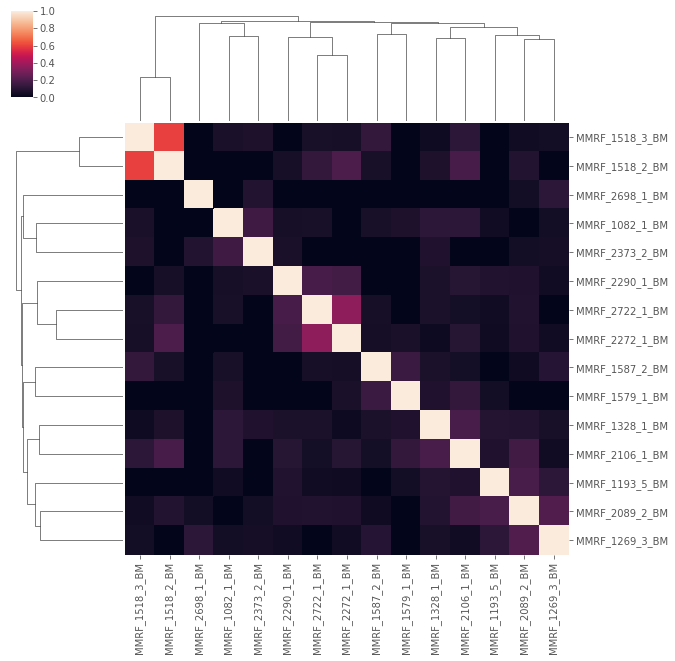

In [110]:
import seaborn as sns
sns.clustermap(pat_mut_jaccard)

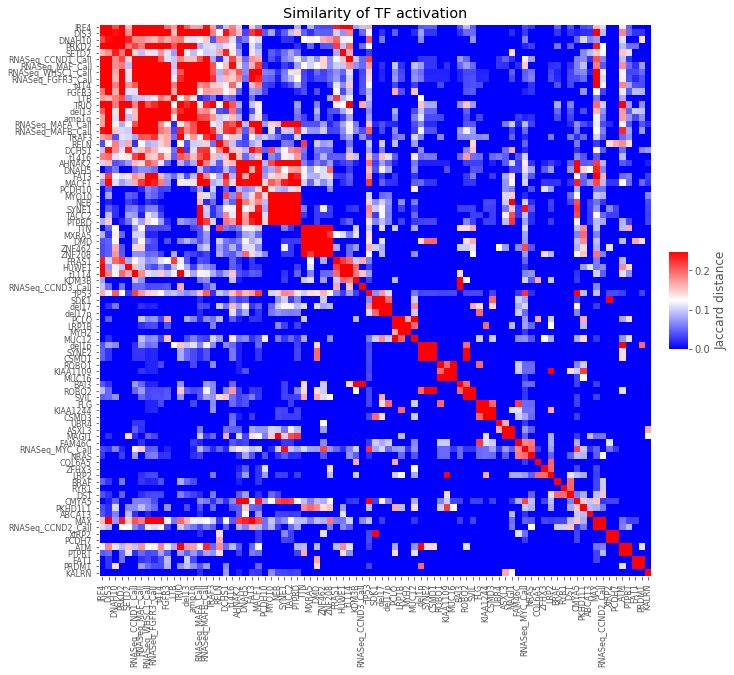

In [83]:
mut_jaccard_15_tmp = mut_tf_jaccard.copy()
mut_jaccard_15_tmp[mut_jaccard_15_tmp<0.15] = 0

clustered_index = miner.unmix(mut_jaccard_15_tmp,iterations=25,returnAll=True)
tf_causal_muts = miner.merge_cluster_list(clustered_index,mut_tf_jaccard,min_corr = 0.5)
#clustered_index = miner.remix(mut_jaccard_15_tmp,clustered_index)
plt.figure(figsize=(12,12))
plt.imshow(mut_tf_jaccard.loc[np.hstack(tf_causal_muts),np.hstack(tf_causal_muts)],cmap="bwr",vmax=0.25)
plt.grid(False)
plt.xticks(np.arange(len(np.hstack(tf_causal_muts))),
           labels=np.hstack(tf_causal_muts),rotation=90,fontsize=8)
plt.yticks(np.arange(len(np.hstack(tf_causal_muts))),
           labels=np.hstack(tf_causal_muts),fontsize=8)
plt.title("Similarity of TF activation")
plt.colorbar(shrink=0.15,label='Jaccard distance',aspect=5,pad=0.025)
plt.savefig(os.path.join(resultsDirectory,"mutation_target_regulator_heatmap.pdf"),bbox_inches="tight")
plt.show()

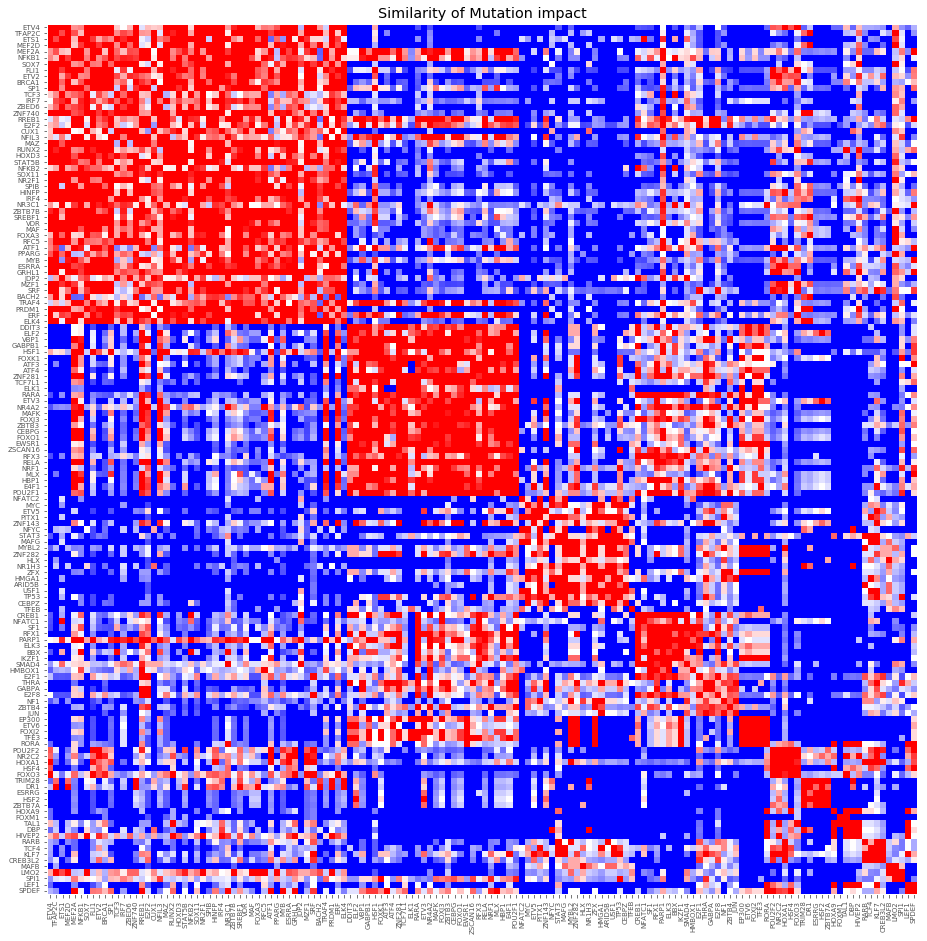

In [61]:
#create distance matrix
tf_mut_jaccard = miner.df_to_jaccard(mut_tf_df.T)

#cluster tfs
mut_jaccard_15_tmp_T = tf_mut_jaccard.copy()
mut_jaccard_15_tmp_T[mut_jaccard_15_tmp_T<0.175] = 0
clustered_index_T = miner.unmix(mut_jaccard_15_tmp_T,iterations=25,returnAll=True)
tf_causal_targets = miner.merge_cluster_list(clustered_index_T,tf_mut_jaccard,min_corr = 0.5)

#plot with merged_clusters
plt.figure(figsize=(16,16))
plt.imshow(tf_mut_jaccard.loc[np.hstack(tf_causal_targets),np.hstack(tf_causal_targets)],cmap="bwr",vmax=0.25)
plt.grid(False)
plt.xticks(np.arange(len(np.hstack(tf_causal_targets))),
           labels=np.hstack(tf_causal_targets),rotation=90,fontsize=7)
plt.yticks(np.arange(len(np.hstack(tf_causal_targets))),
           labels=np.hstack(tf_causal_targets),fontsize=7)
plt.title("Similarity of Mutation impact")
plt.savefig(os.path.join(resultsDirectory,"tf_tf_causal_similarity_heatmap.pdf"),bbox_inches="tight")
plt.show()

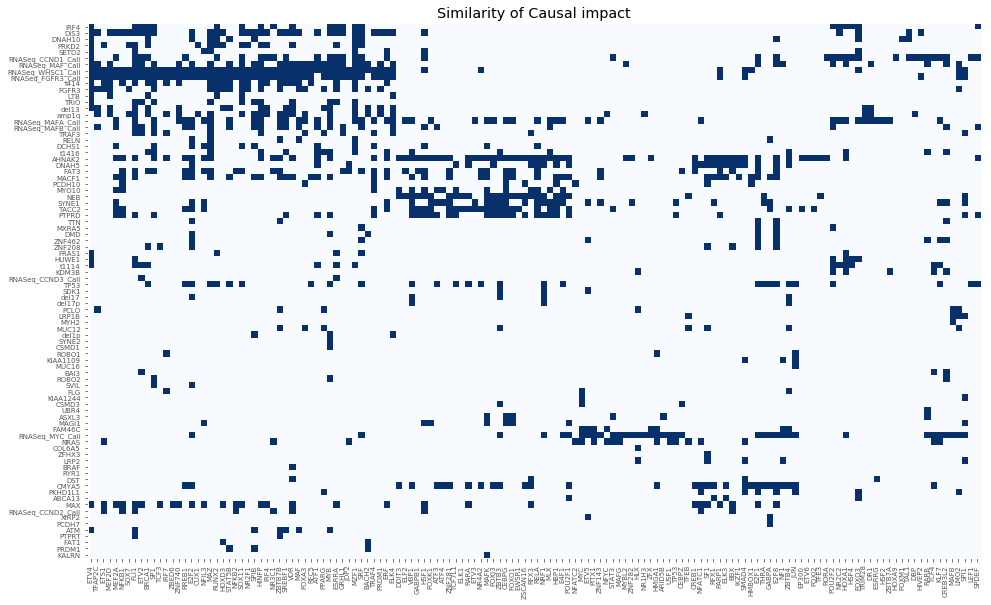

In [84]:
plt.figure(figsize=(16,16))
plt.imshow(mut_tf_df.loc[np.hstack(tf_causal_muts),np.hstack(tf_causal_targets)],cmap="Blues",vmax=0.25)
plt.grid(False)
plt.xticks(np.arange(len(np.hstack(tf_causal_targets))),
           labels=np.hstack(tf_causal_targets),rotation=90,fontsize=7)
plt.yticks(np.arange(len(np.hstack(tf_causal_muts))),
           labels=np.hstack(tf_causal_muts),fontsize=7)
plt.title("Similarity of Causal impact")
plt.savefig(os.path.join(resultsDirectory,"mut_tf_causal_similarity_heatmap.pdf"),bbox_inches="tight")
plt.show()

In [85]:
#common mutations
mean_occurence_muts = common_mutations.loc[miner.intersect(np.hstack(tf_causal_muts),common_mutations.index),
                     miner.intersect(common_mutations.columns,states[14])].mean(axis=1)

#translocations
mean_occurence_translocations = translocations.loc[miner.intersect(np.hstack(tf_causal_muts),translocations.index),
                     miner.intersect(translocations.columns,states[14])].mean(axis=1)

#cytogenetics
mean_occurence_cytogenetics = cytogenetics.loc[miner.intersect(np.hstack(tf_causal_muts),cytogenetics.index),
                     miner.intersect(cytogenetics.columns,states[14])].mean(axis=1)

In [87]:
mean_occurence_translocations["RNASeq_WHSC1_Call"]

0.20833333333333334

In [111]:
mut_occurrence = pd.concat([mean_occurence_muts,mean_occurence_translocations,mean_occurence_cytogenetics])

filter_threshold = 0.1
filtered_muts = mut_occurrence[mut_occurrence>filter_threshold].index
tmp_mut_list = np.hstack(tf_causal_muts)
filtered_mut_list = [mut for mut in tmp_mut_list if mut in filtered_muts]


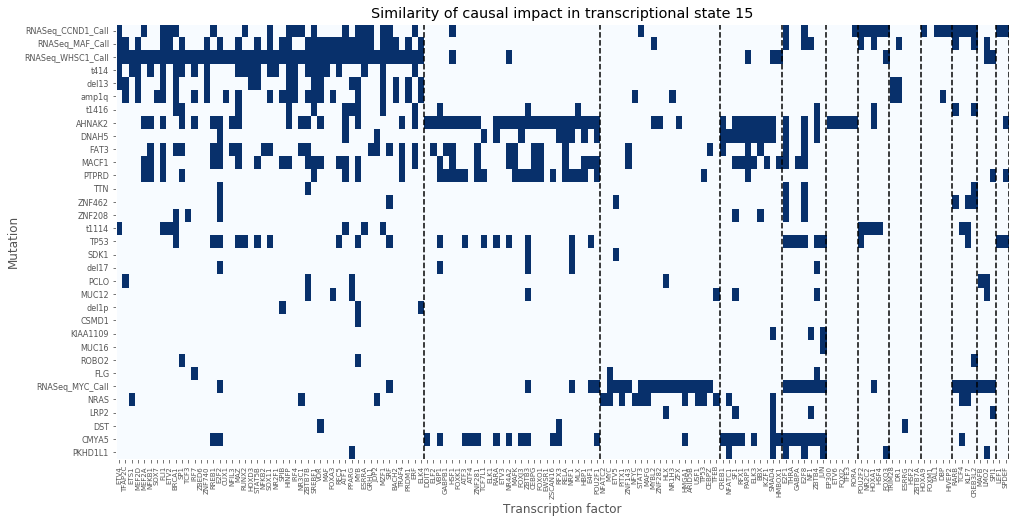

In [147]:
plt.figure(figsize=(16,8))
plt.imshow(mut_tf_df.loc[filtered_mut_list,np.hstack(tf_causal_targets)],cmap="Blues",vmax=0.25,aspect="auto")
start = 0
for i in range(len(tf_causal_targets)):
    start+=len(tf_causal_targets[i])
    plt.axvline(start-0.5,0,
                len(filtered_mut_list),color="k",linestyle="--")
plt.grid(False)
plt.xticks(np.arange(len(np.hstack(tf_causal_targets))),
           labels=np.hstack(tf_causal_targets),rotation=90,fontsize=7)
plt.yticks(np.arange(len(filtered_mut_list)),
           labels=filtered_mut_list,fontsize=8)
plt.ylabel("Mutation")
plt.xlabel("Transcription factor")
plt.title("Similarity of causal impact in transcriptional state 15")
plt.savefig(os.path.join(resultsDirectory,"mut_tf_causal_similarity_heatmap_filtered_10pct.pdf"),bbox_inches="tight")
plt.show()

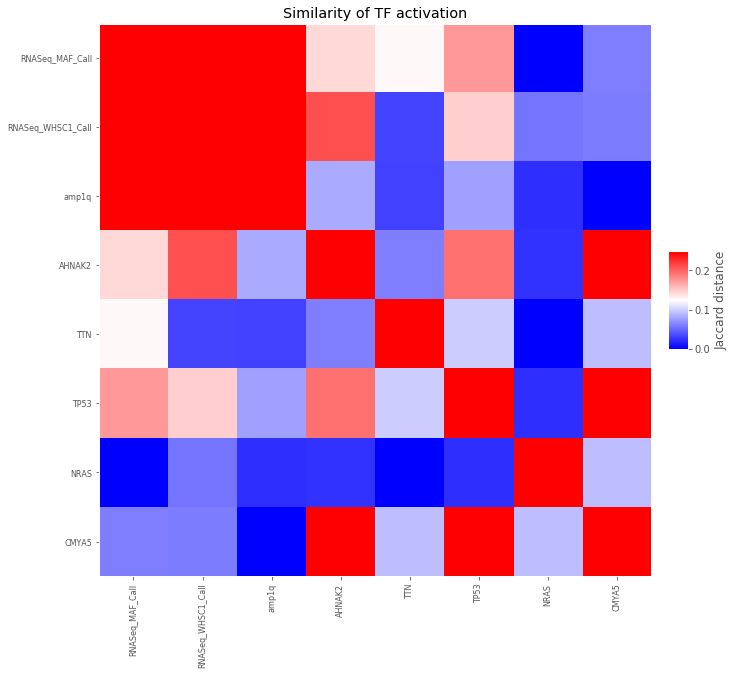

In [104]:
plt.figure(figsize=(12,12))
plt.imshow(mut_tf_jaccard.loc[filtered_mut_list,filtered_mut_list],cmap="bwr",vmax=0.25)
plt.grid(False)
plt.xticks(np.arange(len(filtered_mut_list)),
           labels=filtered_mut_list,rotation=90,fontsize=8)
plt.yticks(np.arange(len(filtered_mut_list)),
           labels=filtered_mut_list,fontsize=8)
plt.title("Similarity of TF activation")
plt.colorbar(shrink=0.15,label='Jaccard distance',aspect=5,pad=0.025)
plt.show()

In [149]:
translocations.loc[:,states[14]].mean(axis=1)

RNASeq_CCND1_Call    0.125000
RNASeq_CCND2_Call    0.041667
RNASeq_CCND3_Call    0.000000
RNASeq_FGFR3_Call    0.083333
RNASeq_MAFA_Call     0.041667
RNASeq_MAFB_Call     0.083333
RNASeq_MAF_Call      0.250000
RNASeq_MYC_Call      0.166667
RNASeq_WHSC1_Call    0.208333
dtype: float64

In [153]:
common_mutations.loc[:,states[14]].mean(axis=1)

KRAS             0.217391
NRAS             0.478261
TTN              0.304348
DIS3             0.086957
FAM46C           0.086957
MUC16            0.173913
TRAF3            0.043478
BRAF             0.000000
PCLO             0.130435
FAT3             0.173913
CSMD3            0.086957
TP53             0.260870
RYR2             0.130435
LRP1B            0.086957
FAT4             0.043478
FAT1             0.043478
RYR1             0.043478
FLG              0.173913
FSIP2            0.086957
DNAH5            0.130435
USH2A            0.130435
EGR1             0.043478
DUSP2            0.086957
HIST1H1E         0.000000
GPR98            0.130435
ATM              0.000000
ZFHX4            0.130435
HMCN1            0.000000
SYNE1            0.086957
HUWE1            0.043478
                   ...   
DNAH11           0.000000
KDM3B            0.043478
MXRA5            0.086957
RP11-1055B8.7    0.000000
COL12A1          0.000000
SHANK1           0.043478
XIRP2            0.043478
FCGBP       

In [ ]:
mut_tf_tf_network_15 = {}

for tmp_tf in tf_network.Target.unique():
    tmp_df = pd.DataFrame(np.vstack(Counter(all_results[all_results.Regulator==tmp_tf]["Mutation"].to_list()
                     ).most_common()))
    tmp_df.set_index(0,inplace=True)
    tmp_df.columns = [tmp_tf]
    tmp_df[tmp_tf] = tmp_df[tmp_tf].astype(float)
    mut_tf_tf_network_15[tmp_tf] = tmp_df[tmp_tf]/tmp_df.max()[0]


In [ ]:

tmp_muts = all_results[all_results.Regulator==tmp_tf]["Mutation"].unique()
for mut in tmp_muts:
    

In [ ]:
tmp_mut = "AHNAK2"
tf_hits = []
for tmp_tf in mut_tf_tf_network_15.keys():
    if tmp_mut in mut_tf_tf_network_15[tmp_tf].index:
        tf_hits.append(tmp_tf)
print(len(tf_hits))
tf_hits

In [ ]:
pd.DataFrame(np.vstack(Counter(all_results[all_results.Regulator=="ETV4"]["Mutation"].to_list()
                 ).most_common()))

In [ ]:
common_mut_pats = miner.intersect(common_mutations.columns,states[14])
common_muts_15 = common_mutations.loc[:,common_mut_pats].sum(axis=1)/len(common_mut_pats)
common_muts_15.sort_values(inplace=True,ascending=False)
common_muts_15 = common_muts_15[common_muts_15>0]

translocations_pats = miner.intersect(translocations.columns,states[14])
translocations_15 = translocations.loc[:,translocations_pats].sum(axis=1)/len(translocations_pats)
translocations_15.sort_values(inplace=True,ascending=False)
translocations_15 = translocations_15[translocations_15>0]

cytogenetics_pats = miner.intersect(cytogenetics.columns,states[14])
cytogenetics_15 = cytogenetics.loc[:,cytogenetics_pats].sum(axis=1)/len(cytogenetics_pats)
cytogenetics_15.sort_values(inplace=True,ascending=False)
cytogenetics_15 = cytogenetics_15[cytogenetics_15>0]


mut_occurrence_15 = pd.concat([pd.DataFrame(translocations_15),
                               pd.DataFrame(common_muts_15),
                               pd.DataFrame(cytogenetics_15)],axis=0)
mut_occurrence_15.columns = ["Frequency"]
mut_occurrence_15.sort_values(by="Frequency",inplace=True,ascending=False)
mut_occurrence_15.to_csv(os.path.join(resultsDirectory,"causal_mutation_frequency_15.csv"))
mut_occurrence_15.head(10)

In [ ]:
#distributions outside of state
common_muts_pats = miner.setdiff(common_mutations.columns,states[14])
common_muts_15_other = common_mutations.loc[:,common_muts_pats].sum(axis=1)/len(common_muts_pats)
common_muts_15_other.sort_values(inplace=True,ascending=False)
common_muts_15_other = common_muts_15_other[common_muts_15_other>0]

translocations_pats = miner.setdiff(translocations.columns,states[14])
translocations_other = translocations.loc[:,translocations_pats].sum(axis=1)/len(translocations_pats)
translocations_other.sort_values(inplace=True,ascending=False)
translocations_other = translocations_other[translocations_other>0]

cytogenetics_pats = miner.setdiff(cytogenetics.columns,states[14])
cytogenetics_other = cytogenetics.loc[:,cytogenetics_pats].sum(axis=1)/len(cytogenetics_pats)
cytogenetics_other.sort_values(inplace=True,ascending=False)
cytogenetics_other = cytogenetics_other[cytogenetics_other>0]


mut_occurrence_other = pd.concat([pd.DataFrame(translocations_other),
                               pd.DataFrame(common_muts_15_other),
                               pd.DataFrame(cytogenetics_other)],axis=0)
mut_occurrence_other.columns = ["Background"]
mut_occurrence_other.sort_values(by="Background",inplace=True,ascending=False)
mut_occurrence_other.to_csv(os.path.join(resultsDirectory,"causal_mutation_frequency_15_other.csv"))
mut_occurrence_other

In [ ]:
order = np.argsort(-1*np.array(mutation_frequency_state_15["Frequency"]-
                            mutation_frequency_state_15["Background"]))

In [ ]:
mutation_frequency_state_15 = pd.concat([mut_occurrence_15,mut_occurrence_other.loc[mut_occurrence_15.index,:]],axis=1)
order = np.argsort(-1*np.array(mutation_frequency_state_15["Frequency"]-
                            mutation_frequency_state_15["Background"]))
mutation_frequency_state_15.iloc[order,:]

In [ ]:
from importlib import reload
reload(miner)
mut_jaccard_all = miner.df_to_jaccard(mutation_matrix)
mut_jaccard_15_muts = miner.df_to_jaccard(mutation_matrix.loc[:,miner.intersect(mutation_matrix.columns,states[14])])

In [ ]:
mut_jaccard_15_tmp = mut_jaccard_15_muts.copy()
mut_jaccard_15_tmp[mut_jaccard_15_tmp<0.25] = 0

clustered_index_muts = miner.unmix(mut_jaccard_15_tmp,iterations=25,returnAll=True)
#clustered_index_muts = miner.remix(mut_jaccard_15_tmp,clustered_index)
plt.figure(figsize=(16,16))
plt.imshow(mut_jaccard_15_muts.loc[np.hstack(clustered_index_muts),np.hstack(clustered_index_muts)],cmap="bwr")
plt.grid(False)
plt.xticks(np.arange(len(np.hstack(clustered_index_muts))),
           labels=np.hstack(clustered_index_muts),rotation=90,fontsize=8)
plt.yticks(np.arange(len(np.hstack(clustered_index_muts))),
           labels=np.hstack(clustered_index_muts),fontsize=8)
plt.title("Likelihood of co-occuring mutations")
plt.colorbar(shrink=0.15,label='Jaccard distance',aspect=5,pad=0.025)
plt.savefig(os.path.join(resultsDirectory,"co_occuring_mutation_heatmap.pdf"),bbox_inches="tight")
plt.show()


In [ ]:
mean_similarity = []
for i in range(len(clustered_index)):
    if len(clustered_index[i])<2:
        continue
    mean_similarity.append(mut_jaccard_15.loc[clustered_index[i],clustered_index[i]].mean().mean())
    
print(np.mean(mean_similarity))

In [ ]:
mutation_matrix.loc[clustered_index[-5],miner.intersect(mutation_matrix.columns,states[14])].sum(axis=0)

## Causal significance testing for translocations

In [ ]:
all_muts = causal_results.Mutation.unique()
mut_list = miner.intersect(all_muts,translocations.index)
print(len(mut_list),"mutations")
cutoffs = np.arange(0,0.6,0.1)

mut_names = []
cutoff_results = []
flow_results = []
cut_sig_results = []
overall_sig_results = []
for i in range(len(mut_list)):
    mut = mut_list[i]
    print(mut)
    mut_names.append(mut)
    tmp_causal = miner.causal_significance_test(causal_results,translocations.copy(),mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)
    
    #test significance against thresholds
    cuts = []
    flows = []
    cut_sig = []
    overall_sig = []
    for cutoff in cutoffs:
        tmp_results = tmp_causal[tmp_causal.Fraction_of_aligned_and_diff_exp_edges>cutoff]
        if tmp_results.shape[0]>0:
            tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]
            tmp_num_flows = tmp_significant_calls.shape[0]
            tmp_fraction_significant = tmp_num_flows/float(tmp_causal.shape[0])
            tmp_fraction_significant_cutoff = tmp_num_flows/float(tmp_results.shape[0])
            #append results
            cuts.append(cutoff)
            flows.append(tmp_num_flows)
            overall_sig.append(tmp_fraction_significant)
            cut_sig.append(tmp_fraction_significant_cutoff)
        else:
            cuts.append(cutoff)
            flows.append(0)
            overall_sig.append(0)
            cut_sig.append(0)
            
    cutoff_results.append(cuts)
    flow_results.append(flows)
    cut_sig_results.append(cut_sig)
    overall_sig_results.append(overall_sig)

    if i%10==0:
        flows_df_translocations = pd.DataFrame(np.vstack(flow_results))
        flows_df_translocations.index = mut_names
        flows_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_flows_translocations.csv"))

        cutsig_df_translocations = pd.DataFrame(np.vstack(cut_sig_results))
        cutsig_df_translocations.index = mut_names
        cutsig_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_cutoff_translocations.csv"))

        overallsig_df_translocations = pd.DataFrame(np.vstack(overall_sig_results))
        overallsig_df_translocations.index = mut_names
        overallsig_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_overall_translocations.csv"))

flows_df_translocations = pd.DataFrame(np.vstack(flow_results))
flows_df_translocations.index = mut_names
flows_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_flows_translocations.csv"))

cutsig_df_translocations = pd.DataFrame(np.vstack(cut_sig_results))
cutsig_df_translocations.index = mut_names
cutsig_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_cutoff_translocations.csv"))

overallsig_df_translocations = pd.DataFrame(np.vstack(overall_sig_results))
overallsig_df_translocations.index = mut_names
overallsig_df_translocations.to_csv(os.path.join(resultsDirectory,"filtered_causal_significance_overall_translocations.csv"))

In [ ]:
for mut in overallsig_df_translocations.index:
    plt.plot(range(overallsig_df_translocations.shape[1]),overallsig_df_translocations.loc[mut,:])
    plt.scatter(range(overallsig_df_translocations.shape[1]),overallsig_df_translocations.loc[mut,:])
    


In [ ]:
for mut in cutsig_df_translocations.index:
    plt.plot(range(cutsig_df_translocations.shape[1]),cutsig_df_translocations.loc[mut,:])
    plt.scatter(range(cutsig_df_translocations.shape[1]),cutsig_df_translocations.loc[mut,:])
    


In [ ]:
for mut in flows_df_translocations.index:
    plt.plot(range(flows_df_translocations.shape[1]),flows_df_translocations.loc[mut,:])
    plt.scatter(range(flows_df_translocations.shape[1]),flows_df_translocations.loc[mut,:])


In [ ]:
#optimized threshold
cutoff = 0.2

#filter causal flows by optimized threshold
t1 = time.time()
all_muts = causal_results.Mutation.unique()
mut_list = miner.intersect(all_muts,translocations.index)
print(len(mut_list),"mutations")

sig_flow_results_translocations = []
for i in range(len(mut_list)):
    mut = mut_list[i]
    print(mut)
    mut_names.append(mut)
    tmp_causal = miner.causal_significance_test(causal_results,translocations.copy(),mut,
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)
    
    #test significance against optimized threshold
    tmp_results = tmp_causal[tmp_causal.Fraction_of_aligned_and_diff_exp_edges>cutoff]
    if tmp_results.shape[0]>0:
        tmp_significant_calls = tmp_results[tmp_results.Fraction_of_aligned_and_diff_exp_edges>tmp_results.upper_95]
        #list regulators
        regulators = [
            regulonDf[regulonDf.Regulon_ID==int(reg)]["Regulator"].unique()[0] 
            for reg in tmp_significant_calls.index
        ]
        #format significant causal flows
        tmp_cm_df = pd.DataFrame(list(zip(
            [mut for i in range(tmp_significant_calls.shape[0])],
            regulators,
            tmp_significant_calls.index)))
        tmp_cm_df.columns = ["Mutation","Regulator","Regulon"]
        
        #add dataframe to list for concatenation
        sig_flow_results_translocations.append(tmp_cm_df)

    if i%10==0:
        tmp_results = pd.concat(sig_flow_results_translocations,axis=0)
        tmp_results.to_csv(os.path.join(resultsDirectory,"sig_causal_flows_translocations.csv"))

final_cm_results_translocations = pd.concat(sig_flow_results_translocations,axis=0)
final_cm_results_translocations.to_csv(os.path.join(resultsDirectory,"sig_causal_flows_translocations.csv"))
    
t2 = time.time()
print((t2-t1)/60.0)

In [ ]:
final_cm_results_translocations.shape

In [ ]:
### save every file while sampling first 20
### save only files that pass the cutoff for the rest
### concatenate all results at the end

In [ ]:
prdm1_causal = causal_significance_test(causal_results,common_mutations.copy(),"PRDM1",
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)

In [ ]:
dis3_causal = causal_significance_test(causal_results,common_mutations.copy(),"DIS3",
                             regulonDf,eigengenes,expressionData,network_activity_diff,
                             n_iter=10)


In [ ]:
data_df_prdm1 =  make_data_df(prdm1_causal,cutoffs)
data_df_dis3 =  make_data_df(dis3_causal,cutoffs)

In [ ]:

#Plot 3 representative results
freq = data_df.groupby("cutoff").mean()["flows"].to_list()
number_gp = len(cutoffs)

# freq = the percentage for each age group, and there’re 7 age groups.
def ax_settings(ax, var_name, x_min, x_max):
    ax.set_xlim(x_min,x_max)
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.spines['bottom'].set_edgecolor('#444444')
    ax.spines['bottom'].set_linewidth(2)
    
    ax.text(-0.1, 0.05, var_name, fontsize=14, fontweight="bold", transform = ax.transAxes) 
    return None

# Manipulate each axes object in the left. Try to tune some parameters and you'll know how each command works.
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style="white",font_scale=1.4)

#instantiate figure
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(nrows=number_gp, 
                       ncols=3, 
                       figure=fig, 
                       width_ratios= [1, 1, 1],
                       height_ratios= [1]*number_gp,
                       wspace=0.2, hspace=0.05
                      )
#instantiate axes
ax = [None]*(number_gp*3)

#collect groupby features (i.e., cutoffs)
features = data_df.groupby("cutoff").mean()["flows"].index.to_list()

# Create the left panel 
for i in range(number_gp):
    ax[i] = fig.add_subplot(gs[i, 0])
    
    ax_settings(ax[i], str(features[i]), -0.2, 1.2)    
    
    sns.kdeplot(data=data_df_prdm1[(data_df_prdm1.type == 'Permutation') & (data_df_prdm1.cutoff == features[i])].value, 
            ax=ax[i], shade=True, color="blue", legend=False)
    sns.kdeplot(data=data_df_prdm1[(data_df_prdm1.type == 'Observed') & (data_df_prdm1.cutoff == features[i])].value, 
            ax=ax[i], shade=True, color="red", legend=False)
    
    if i < (number_gp - 1): 
        ax[i].set_xticks([])
              
#Set legend
ax[0].legend(['Perm. 95%', 'PRDM1'], facecolor='w',fontsize=12)
ax[number_gp-1].set_xlabel('Causal metric',fontsize=14)

# Create the middle panel 
for i in range(number_gp):
    ax[i+number_gp] = fig.add_subplot(gs[i, 1])
    
    ax_settings(ax[i+number_gp], str(features[i]), -0.2, 1.2)    
    
    sns.kdeplot(data=data_df_dis3[(data_df_dis3.type == 'Permutation') & (data_df_dis3.cutoff == features[i])].value, 
            ax=ax[i+number_gp], shade=True, color="blue", legend=False)
    sns.kdeplot(data=data_df_dis3[(data_df_dis3.type == 'Observed') & (data_df_dis3.cutoff == features[i])].value, 
            ax=ax[i+number_gp], shade=True, color="red", legend=False)
    
    if i < (number_gp - 1): 
        ax[i+number_gp].set_xticks([])
              
#Set legend
ax[number_gp].legend(['Perm. 95%', 'DIS3'], facecolor='w',fontsize=12)
ax[2*number_gp-1].set_xlabel('Causal metric',fontsize=14)

# Create the right panel 
for i in range(number_gp):
    ax[i+2*number_gp] = fig.add_subplot(gs[i, 2])
    
    ax_settings(ax[i+2*number_gp], str(features[i]), -0.2, 1.2)    
    
    sns.kdeplot(data=data_df[(data_df.type == 'Permutation') & (data_df.cutoff == features[i])].value, 
            ax=ax[i+2*number_gp], shade=True, color="blue", legend=False)
    sns.kdeplot(data=data_df[(data_df.type == 'Observed') & (data_df.cutoff == features[i])].value, 
            ax=ax[i+2*number_gp], shade=True, color="red", legend=False)
    
    if i < (number_gp - 1): 
        ax[i+2*number_gp].set_xticks([])
              
#Set legend
ax[2*number_gp].legend(['Perm. 95%', 't(14;16)'], facecolor='w',fontsize=12)
ax[3*number_gp-1].set_xlabel('Causal metric',fontsize=14)

plt.savefig(os.path.join(resultsDirectory,"causal_joyplot.pdf"),bbox_inches="tight")
plt.show()

In [ ]:
len(miner.getMutations("KRAS",common_mutations))

## other work

In [ ]:
nsd2 = "ENSG00000109685"
ccnd1 = "ENSG00000110092"
myc = "ENSG00000136997"

In [ ]:
min_state_size = 2
bplots = np.array([list(expressionData.loc[nsd2,states[i]]) 
                   for i in range(len(states)) if len(states[i])>min_state_size],dtype=object)
names = [i+1 for i in range(len(states)) if len(states[i])>min_state_size]
plt.figure(figsize=(12,3))
plt.boxplot(bplots,labels=names)
plt.ylabel("NSD2 expression",fontsize=14)
plt.xlabel("State",fontsize=14)
plt.show()

In [ ]:
min_state_size = 2
bplots = np.array([list(expressionData.loc[ccnd1,states[i]]) 
                   for i in range(len(states)) if len(states[i])>min_state_size],dtype=object)
names = [i+1 for i in range(len(states)) if len(states[i])>min_state_size]
plt.figure(figsize=(12,3))
plt.boxplot(bplots,labels=names)
plt.ylabel("CCND1 expression",fontsize=14)
plt.xlabel("State",fontsize=14)
plt.ylim(-2.5,2.5)
plt.show()

In [ ]:
min_state_size = 2
bplots = np.array([list(expressionData.loc[myc,states[i]]) 
                   for i in range(len(states)) if len(states[i])>min_state_size],dtype=object)
names = [i+1 for i in range(len(states)) if len(states[i])>min_state_size]
plt.figure(figsize=(12,3))
plt.boxplot(bplots,labels=names)
plt.ylabel("MYC expression",fontsize=14)
plt.xlabel("State",fontsize=14)
plt.ylim(-4.5,2.5)
plt.show()

In [ ]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)


In [ ]:
referenceMatrix = eigengenes.copy()
primaryMatrix = overExpressedMembersMatrix
secondaryMatrix = underExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryDictionary = underExpressedMembers
minClusterSize=5
restricted_index=None    
    

t1 = time.time()

print('Beginning subtype inference')
if restricted_index is not None:
    referenceMatrix = referenceMatrix.loc[restricted_index,:]
    primaryMatrix = primaryMatrix.loc[restricted_index,:]
    secondaryMatrix = secondaryMatrix.loc[restricted_index,:]

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(primaryDictionary,thresholdSFM=0.1)
similarityClusters = [list(set(cluster)&set(referenceMatrix.columns)) for cluster in similarityClusters]
initialClasses = [i for i in similarityClusters if len(i)>4]
if len(initialClasses)==0:
    print('No subtypes were detected')

# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,primaryMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3

subcentroidClusters = []
for c in range(len(centroidClusters)):
    tmp_cluster = centroidClusters[c]
    if len(tmp_cluster) < 2*minClusterSize:
        if len(tmp_cluster)>0:
            subcentroidClusters.append(tmp_cluster)
        continue

    sampleDictionary = {key:list(set(tmp_cluster)&set(secondaryDictionary[key])) for key in secondaryDictionary}
    sampleMatrix = secondaryMatrix.loc[:,tmp_cluster]

    # perform initial subtype clustering
    similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
    initialClasses = [i for i in similarityClusters if len(i)>4]
    if len(initialClasses)==0:
        subcentroidClusters.append(tmp_cluster)
        continue

    # expand initial subtype clusters
    tmp_centroidClusters, tmp_centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
    tmp_centroidClusters.sort(key=len,reverse=True)

    if len(tmp_centroidClusters) <= 1:
        subcentroidClusters.append(tmp_cluster)
        continue

    for cc in range(len(tmp_centroidClusters)):            
        new_cluster = tmp_centroidClusters[cc]
        if len(new_cluster)==0:
            continue
        if len(new_cluster) < minClusterSize: 
            if cc == 0:
                other_clusters = []
                other_clusters.append(np.hstack(tmp_centroidClusters))
                tmp_centroidClusters = other_clusters
                break
            other_clusters = tmp_centroidClusters[0:cc]
            new_centroids = miner.getCentroids(other_clusters,referenceMatrix)
            unlabeled = list(set(np.hstack(tmp_centroidClusters))-set(np.hstack(other_clusters)))
            for sample in unlabeled:
                pearson = miner.pearson_array(np.array(new_centroids).T,np.array(referenceMatrix.loc[:,sample]))
                top_hit = np.argsort(pearson)[-1]
                other_clusters[top_hit].append(sample)
            tmp_centroidClusters = other_clusters
            break

        elif len(new_cluster) >= minClusterSize:
            continue

    for ccc in range(len(tmp_centroidClusters)):
        if len(tmp_centroidClusters[ccc]) == 0:
            continue
        subcentroidClusters.append(tmp_centroidClusters[ccc])

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))


In [ ]:
#Append significant mutations to causal states data
